## Optimización de la Estrategia de Carrera en Fórmula 1 mediante Investigación Operativa: Aplicación al Gran Premio de Madrid

La estrategia de carrera en Fórmula 1 constituye un problema complejo de toma de decisiones en el que intervienen factores reglamentarios, técnicos y estratégicos. La elección del número de paradas en boxes, los compuestos de neumáticos, el ritmo de conducción y la gestión de recursos como el combustible o la degradación de los neumáticos influyen de manera decisiva en el tiempo total de carrera.

El objetivo de este trabajo es formular y resolver un problema de Investigación Operativa que modele la planificación óptima de la estrategia de carrera para un Gran Premio urbano, concretamente el Gran Premio de Madrid, utilizando herramientas de programación matemática.

El modelo propuesto es de tipo **MINLP (Mixed-Integer Nonlinear Programming)**, combinando:
- **Variables binarias**: decisiones discretas (compuestos, modos, reglajes)
- **Variables continuas**: magnitudes físicas (duración, tiempo, degradación)
- **No linealidades**: degradación cuadrática de neumáticos y productos de variables

A lo largo del notebook se presenta la formulación matemática completa del problema, la implementación computacional del modelo, la resolución del mismo y un análisis de sensibilidad que permite estudiar cómo varía la estrategia óptima ante cambios en los parámetros del entorno.

---

<div style="text-align: center;">
<img src="imagenes/Imagen1.jpg" alt="Modelo conceptual de estrategia de carrera" width="800"/>

<p><em>Representación conceptual de la planificación estratégica de carrera y la optimización del rendimiento mediante análisis de datos.</em></p>
</div>

---

### Índice de Contenidos

| Sección | Contenido |
|:--------|:----------|
| [1. Descripción del problema](#seccion-1) | Planteamiento del problema de optimización |
| [2. Conjuntos e índices](#seccion-2) | Definición de los conjuntos matemáticos |
| [3. Variables de decisión](#seccion-3) | 48 variables: 35 binarias + 13 continuas |
| [4. Función objetivo](#seccion-4) | Minimización del tiempo total de carrera |
| [5. Restricciones del modelo](#seccion-5) | 43 restricciones del problema |
| [6. Implementación del modelo](#seccion-6) | Código en Pyomo con solver SCIP |
| [7. Alcance y extensiones](#seccion-7) | Posibilidades del modelo |
| [8. Análisis de Dualidad y Precios Sombra](#seccion-8) | Precios sombra, holguras y KKT |
| [9. Análisis de Escenarios](#seccion-9) | Normal, Calor, Lluvia, Safety Car, VSC |
| [10. Visualizaciones Avanzadas](#seccion-10) | Gráficos y diagramas de la estrategia |

<a id="seccion-1"></a>

### 1. Descripción del problema

Este trabajo aborda el problema de la planificación óptima de la estrategia de carrera para un equipo de Fórmula 1 durante el nuevo Gran Premio de Madrid, considerado como un circuito urbano con alta exigencia en la gestión de neumáticos y una elevada probabilidad de interrupciones.

El objetivo principal es minimizar el tiempo total de carrera mediante la toma de decisiones estratégicas previas a la salida, considerando tanto restricciones reglamentarias como limitaciones físicas del vehículo. Para ello, se modelan de forma explícita las decisiones relacionadas con:

- la elección de los compuestos de neumáticos,
- el número y momento de las paradas en boxes,
- el ritmo de conducción durante los distintos stints (intervalos con un mismo neumático),
- la configuración global del vehículo (reglajes y configuraciones del vehículo),
- y la gestión de recursos como el combustible y la degradación de los neumáticos.

El problema se formula bajo un enfoque de planificación previa a la carrera, en el que se asume que las decisiones estratégicas se determinan antes del inicio del Gran Premio, a partir de estimaciones conocidas del rendimiento del coche, el comportamiento de los neumáticos y las penalizaciones asociadas a las paradas en boxes. Aunque durante una carrera real estas decisiones pueden adaptarse dinámicamente, este planteamiento permite capturar la esencia del problema estratégico sin introducir una complejidad excesiva.

Desde el punto de vista reglamentario, el modelo incorpora las principales restricciones impuestas por la Federación Internacional del Automóvil (FIA), como el uso obligatorio de al menos dos compuestos diferentes de neumáticos en condiciones de carrera en seco y la disponibilidad limitada de juegos de neumáticos. Asimismo, se consideran restricciones técnicas relacionadas con el consumo mínimo de combustible al final de la carrera y con la vida útil máxima de los neumáticos.

Para representar el comportamiento del vehículo, se introducen variables continuas que describen la evolución del combustible, la degradación del neumático y el tiempo acumulado de carrera. Los efectos de decisiones técnicas más finas, como la gestión detallada de sistemas híbridos o ajustes dinámicos del vehículo, se integran de forma implícita en los parámetros del modelo, reflejándose en los tiempos base, los consumos y las tasas de degradación estimadas.

De este modo, el problema queda formulado como un modelo de Investigación Operativa que combina decisiones discretas y continuas, permitiendo analizar de forma estructurada el compromiso entre rendimiento, gestión de recursos y cumplimiento del reglamento en un contexto realista de competición automovilística.

---

<a id="seccion-2"></a>

### 2. Conjuntos e índices

Para la formulación del modelo se definen los siguientes conjuntos:

---

#### Conjunto de stints potenciales

$$S = \{1, 2, 3, 4\}$$

donde cada elemento representa un stint potencial de la carrera. El número máximo de stints ($S_{max} = 4$) se elige suficientemente amplio para no restringir artificialmente la solución.

---

#### Conjunto de compuestos de neumáticos

$$C = \{Soft, Medium, Hard, Inter\}$$

Este conjunto incluye los tres compuestos de neumáticos de seco disponibles para la carrera (Soft, Medium, Hard) más el compuesto intermedio (Inter) para condiciones de lluvia.

---

#### Conjunto de modos de conducción

$$M = \{Push, Balanced, Save\}$$

Define el ritmo al que se puede disputar cada stint:
- **Push**: ritmo agresivo, más rápido pero mayor degradación
- **Balanced**: ritmo equilibrado
- **Save**: ritmo conservador, más lento pero menor degradación

---

#### Conjunto de reglajes aerodinámicos

$$R = \{Low, Balanced, High\}$$

Representa las posibles configuraciones aerodinámicas globales del monoplaza:
- **Low**: baja carga aerodinámica (más velocidad en rectas)
- **Balanced**: configuración equilibrada
- **High**: alta carga aerodinámica (más agarre en curvas)

---

### Parámetros del modelo

Los parámetros representan información conocida o estimada antes del inicio de la carrera:

| Parámetro | Descripción | Valor |
|-----------|-------------|-------|
| $L$ | Número de vueltas del GP Madrid | 57 |
| $P_{stint}$ | Penalización por parada en boxes | 32 s |
| $l_{min}$ | Duración mínima de un stint | 1 vuelta |
| $\gamma$ | Factor de conversión degradación-tiempo | 0.5 |

#### Tiempos base por vuelta (segundos)

| Compuesto | Push | Balanced | Save |
|-----------|------|----------|------|
| Soft | 80.0 | 83.5 | 87.0 |
| Medium | 85.5 | 89.0 | 92.5 |
| Hard | 90.0 | 93.5 | 97.0 |
| Inter | 98.0 | 103.0 | 106.0 |

#### Coeficientes de degradación cuadrática ($\alpha_c$)

| Compuesto | $\alpha$ | Vida máxima | Stock |
|-----------|----------|-------------|-------|
| Soft | 0.035 | 15 vueltas | 2 juegos |
| Medium | 0.020 | 28 vueltas | 2 juegos |
| Hard | 0.010 | 42 vueltas | 1 juego |
| Inter | 0.015 | 27 vueltas | 10 juegos |

#### Ajuste por reglaje aerodinámico ($\delta_r$)

| Reglaje | Ajuste (s/vuelta) |
|---------|------------------|
| Low | -0.3 |
| Balanced | 0.0 |
| High | +0.25 |

---

<a id="seccion-3"></a>

### 3. Variables de decisión

El modelo incluye un conjunto de **48 variables de decisión** que representan las elecciones estratégicas y operativas realizadas por el equipo a lo largo de la carrera, así como variables continuas que describen el estado físico del sistema.

---

#### Variables binarias de activación de stint (4 variables)

$$y_s \in \{0,1\} \quad \forall s \in S$$

Vale 1 si el stint $s$ está activo en la estrategia.

| Variable | Descripción |
|----------|-------------|
| $y_1$ | Activación del stint 1 |
| $y_2$ | Activación del stint 2 |
| $y_3$ | Activación del stint 3 |
| $y_4$ | Activación del stint 4 |

---

#### Variables binarias de elección de compuesto (16 variables)

$$x_{s,c} \in \{0,1\} \quad \forall s \in S, \forall c \in C$$

Vale 1 si el stint $s$ utiliza el compuesto $c$.

| Stint | Soft | Medium | Hard | Inter |
|-------|------|--------|------|-------|
| 1 | $x_{1,Soft}$ | $x_{1,Med}$ | $x_{1,Hard}$ | $x_{1,Inter}$ |
| 2 | $x_{2,Soft}$ | $x_{2,Med}$ | $x_{2,Hard}$ | $x_{2,Inter}$ |
| 3 | $x_{3,Soft}$ | $x_{3,Med}$ | $x_{3,Hard}$ | $x_{3,Inter}$ |
| 4 | $x_{4,Soft}$ | $x_{4,Med}$ | $x_{4,Hard}$ | $x_{4,Inter}$ |

---

#### Variables binarias de elección de modo (12 variables)

$$z_{s,m} \in \{0,1\} \quad \forall s \in S, \forall m \in M$$

Vale 1 si el stint $s$ se disputa con el modo de conducción $m$.

| Stint | Push | Balanced | Save |
|-------|------|----------|------|
| 1 | $z_{1,Push}$ | $z_{1,Bal}$ | $z_{1,Save}$ |
| 2 | $z_{2,Push}$ | $z_{2,Bal}$ | $z_{2,Save}$ |
| 3 | $z_{3,Push}$ | $z_{3,Bal}$ | $z_{3,Save}$ |
| 4 | $z_{4,Push}$ | $z_{4,Bal}$ | $z_{4,Save}$ |

---

#### Variables binarias de reglaje aerodinámico (3 variables)

$$w_r \in \{0,1\} \quad \forall r \in R$$

Vale 1 si se selecciona el reglaje aerodinámico $r$ para toda la carrera.

| Variable | Descripción |
|----------|-------------|
| $w_{Low}$ | Selección de baja carga aerodinámica |
| $w_{Balanced}$ | Selección de configuración equilibrada |
| $w_{High}$ | Selección de alta carga aerodinámica |

---

#### Variables continuas de duración (4 variables)

$$l_s \geq 0 \quad \forall s \in S$$

Número de vueltas del stint $s$.

| Variable | Descripción |
|----------|-------------|
| $l_1$ | Duración del stint 1 (vueltas) |
| $l_2$ | Duración del stint 2 (vueltas) |
| $l_3$ | Duración del stint 3 (vueltas) |
| $l_4$ | Duración del stint 4 (vueltas) |

---

#### Variables continuas de tiempo por stint (4 variables)

$$T_s \geq 0 \quad \forall s \in S$$

Tiempo total consumido en el stint $s$ (segundos).

| Variable | Descripción |
|----------|-------------|
| $T_1$ | Tiempo del stint 1 (segundos) |
| $T_2$ | Tiempo del stint 2 (segundos) |
| $T_3$ | Tiempo del stint 3 (segundos) |
| $T_4$ | Tiempo del stint 4 (segundos) |

---

#### Variables continuas de degradación (4 variables)

$$D_s \geq 0 \quad \forall s \in S$$

Degradación acumulada del neumático en el stint $s$.

| Variable | Descripción |
|----------|-------------|
| $D_1$ | Degradación acumulada en stint 1 |
| $D_2$ | Degradación acumulada en stint 2 |
| $D_3$ | Degradación acumulada en stint 3 |
| $D_4$ | Degradación acumulada en stint 4 |

---

#### Variable objetivo (1 variable)

$$T_{total} \geq 0$$

Tiempo total de carrera (variable a minimizar).

---

### Resumen de variables

| Tipo | Cantidad | Descripción |
|------|----------|-------------|
| **Binarias** | | |
| $y_s$ | 4 | Activación de stint |
| $x_{s,c}$ | 16 | Elección de compuesto |
| $z_{s,m}$ | 12 | Elección de modo |
| $w_r$ | 3 | Elección de reglaje |
| **Subtotal binarias** | **35** | |
| **Continuas** | | |
| $l_s$ | 4 | Duración del stint |
| $T_s$ | 4 | Tiempo del stint |
| $D_s$ | 4 | Degradación del stint |
| $T_{total}$ | 1 | Tiempo total |
| **Subtotal continuas** | **13** | |
| | | |
| **TOTAL VARIABLES** | **48** | |

---

<a id="seccion-4"></a>

### 4. Función objetivo

El objetivo del modelo es **minimizar el tiempo total de carrera**, teniendo en cuenta tanto el rendimiento en pista como las penalizaciones asociadas a las decisiones estratégicas adoptadas.

La variable $T_{total}$ representa el tiempo total empleado para completar el Gran Premio de Madrid. Por tanto, la función objetivo del problema se define como:

$$
\min \; T_{total}
$$

El tiempo total de carrera depende de múltiples factores que se incorporan de forma estructurada en el modelo a través de las variables y parámetros definidos previamente. En particular, el valor de $T_{total}$ se ve afectado por:

- los tiempos base por vuelta, que dependen del compuesto de neumáticos utilizado, el ritmo de conducción y la configuración aerodinámica del vehículo,
- la evolución del tráfico en pista, especialmente tras las reincorporaciones desde boxes,
- y las penalizaciones temporales asociadas a las paradas en boxes.

De manera implícita, la función objetivo recoge los compromisos entre un ritmo de carrera más agresivo, que permite reducir el tiempo por vuelta a costa de un mayor consumo y degradación, y estrategias más conservadoras, que priorizan la gestión de recursos pero incrementan el tiempo total. El modelo determina automáticamente la combinación de decisiones que conduce al menor tiempo total de carrera respetando todas las restricciones reglamentarias, físicas y estratégicas.

La minimización del tiempo total permite obtener una estrategia de carrera óptima desde el punto de vista de la planificación previa, proporcionando una base cuantitativa para comparar distintas alternativas estratégicas.

---

<a id="seccion-5"></a>

### 5. Restricciones del modelo

El modelo incluye un total de **43 restricciones** que garantizan la coherencia lógica del modelo, el cumplimiento del reglamento deportivo y la viabilidad física de la estrategia de carrera.

---

#### 5.1 Restricciones estructurales (12 restricciones)

**Cobertura total de la carrera (1 restricción)**

$$\sum_{s \in S} l_s = 57$$

La suma de las vueltas de todos los stints debe igualar el total de vueltas del GP.

---

**Acoplamiento activación-duración (4 restricciones)**

$$l_s \leq 57 \cdot y_s \quad \forall s \in S$$

| Restricción | Expresión |
|-------------|----------|
| R1 | $l_1 \leq 57 \cdot y_1$ |
| R2 | $l_2 \leq 57 \cdot y_2$ |
| R3 | $l_3 \leq 57 \cdot y_3$ |
| R4 | $l_4 \leq 57 \cdot y_4$ |

Un stint solo puede tener vueltas si está activo.

---

**Orden lógico de stints (3 restricciones)**

$$y_{s+1} \leq y_s \quad \forall s \in \{1,2,3\}$$

| Restricción | Expresión |
|-------------|----------|
| R5 | $y_2 \leq y_1$ |
| R6 | $y_3 \leq y_2$ |
| R7 | $y_4 \leq y_3$ |

Los stints deben activarse en orden (no puede haber huecos).

---

**Duración mínima por stint activo (4 restricciones)**

$$l_s \geq l_{min} \cdot y_s \quad \forall s \in S$$

| Restricción | Expresión |
|-------------|----------|
| R8 | $l_1 \geq 1 \cdot y_1$ |
| R9 | $l_2 \geq 1 \cdot y_2$ |
| R10 | $l_3 \geq 1 \cdot y_3$ |
| R11 | $l_4 \geq 1 \cdot y_4$ |

Todo stint activo debe tener al menos 1 vuelta.

---

#### 5.2 Restricciones de elección (9 restricciones)

**Un compuesto por stint (4 restricciones)**

$$\sum_{c \in C} x_{s,c} = y_s \quad \forall s \in S$$

| Restricción | Expresión |
|-------------|----------|
| R12 | $x_{1,Soft} + x_{1,Med} + x_{1,Hard} + x_{1,Inter} = y_1$ |
| R13 | $x_{2,Soft} + x_{2,Med} + x_{2,Hard} + x_{2,Inter} = y_2$ |
| R14 | $x_{3,Soft} + x_{3,Med} + x_{3,Hard} + x_{3,Inter} = y_3$ |
| R15 | $x_{4,Soft} + x_{4,Med} + x_{4,Hard} + x_{4,Inter} = y_4$ |

---

**Un modo de conducción por stint (4 restricciones)**

$$\sum_{m \in M} z_{s,m} = y_s \quad \forall s \in S$$

| Restricción | Expresión |
|-------------|----------|
| R16 | $z_{1,Push} + z_{1,Bal} + z_{1,Save} = y_1$ |
| R17 | $z_{2,Push} + z_{2,Bal} + z_{2,Save} = y_2$ |
| R18 | $z_{3,Push} + z_{3,Bal} + z_{3,Save} = y_3$ |
| R19 | $z_{4,Push} + z_{4,Bal} + z_{4,Save} = y_4$ |

---

**Un reglaje aerodinámico global (1 restricción)**

$$\sum_{r \in R} w_r = 1$$

| Restricción | Expresión |
|-------------|----------|
| R20 | $w_{Low} + w_{Balanced} + w_{High} = 1$ |

---

#### 5.3 Restricciones reglamentarias FIA (9 restricciones)

**Mínimo 2 stints - parada obligatoria (1 restricción)**

$$\sum_{s \in S} y_s \geq 2$$

| Restricción | Expresión |
|-------------|----------|
| R21 | $y_1 + y_2 + y_3 + y_4 \geq 2$ |

---

**Vida máxima del neumático (4 restricciones)**

$$l_s \leq \sum_{c \in C} VidaMax_c \cdot x_{s,c} \quad \forall s \in S$$

| Restricción | Expresión |
|-------------|----------|
| R22 | $l_1 \leq 15 \cdot x_{1,Soft} + 28 \cdot x_{1,Med} + 42 \cdot x_{1,Hard} + 27 \cdot x_{1,Inter}$ |
| R23 | $l_2 \leq 15 \cdot x_{2,Soft} + 28 \cdot x_{2,Med} + 42 \cdot x_{2,Hard} + 27 \cdot x_{2,Inter}$ |
| R24 | $l_3 \leq 15 \cdot x_{3,Soft} + 28 \cdot x_{3,Med} + 42 \cdot x_{3,Hard} + 27 \cdot x_{3,Inter}$ |
| R25 | $l_4 \leq 15 \cdot x_{4,Soft} + 28 \cdot x_{4,Med} + 42 \cdot x_{4,Hard} + 27 \cdot x_{4,Inter}$ |

---

**Stock disponible de neumáticos (4 restricciones)**

$$\sum_{s \in S} x_{s,c} \leq Stock_c \quad \forall c \in C$$

| Restricción | Expresión |
|-------------|----------|
| R26 | $x_{1,Soft} + x_{2,Soft} + x_{3,Soft} + x_{4,Soft} \leq 2$ |
| R27 | $x_{1,Med} + x_{2,Med} + x_{3,Med} + x_{4,Med} \leq 2$ |
| R28 | $x_{1,Hard} + x_{2,Hard} + x_{3,Hard} + x_{4,Hard} \leq 1$ |
| R29 | $x_{1,Inter} + x_{2,Inter} + x_{3,Inter} + x_{4,Inter} \leq 10$ |

---

#### 5.4 Restricciones de prohibición de Inter en seco (4 restricciones)

$$x_{s,Inter} \leq Rain \quad \forall s \in S$$

| Restricción | Expresión |
|-------------|----------|
| R30 | $x_{1,Inter} \leq Rain$ |
| R31 | $x_{2,Inter} \leq Rain$ |
| R32 | $x_{3,Inter} \leq Rain$ |
| R33 | $x_{4,Inter} \leq Rain$ |

Si $Rain = 0$, no se pueden usar neumáticos Inter.

---

#### 5.5 Restricciones físicas (9 restricciones)

**Degradación cuadrática del neumático (4 restricciones)**

$$D_s \geq \sum_{c \in C} \alpha_c \cdot x_{s,c} \cdot l_s^2 \quad \forall s \in S$$

| Restricción | Expresión |
|-------------|----------|
| R34 | $D_1 \geq 0.035 \cdot x_{1,Soft} \cdot l_1^2 + 0.020 \cdot x_{1,Med} \cdot l_1^2 + 0.010 \cdot x_{1,Hard} \cdot l_1^2 + 0.015 \cdot x_{1,Inter} \cdot l_1^2$ |
| R35 | $D_2 \geq 0.035 \cdot x_{2,Soft} \cdot l_2^2 + ...$ |
| R36 | $D_3 \geq 0.035 \cdot x_{3,Soft} \cdot l_3^2 + ...$ |
| R37 | $D_4 \geq 0.035 \cdot x_{4,Soft} \cdot l_4^2 + ...$ |

**Nota:** Estas son restricciones **no lineales** (productos de variables binarias y continuas elevadas al cuadrado).

---

**Cálculo del tiempo por stint (4 restricciones)**

$$T_s = \sum_{c \in C} \sum_{m \in M} T_{base}(c,m) \cdot x_{s,c} \cdot z_{s,m} \cdot l_s + \sum_{r \in R} \delta_r \cdot w_r \cdot l_s + \gamma \cdot D_s \quad \forall s \in S$$

| Restricción | Componentes |
|-------------|-------------|
| R38 | $T_1 = (tiempo\_base) \cdot l_1 + (ajuste\_reglaje) \cdot l_1 + 0.5 \cdot D_1$ |
| R39 | $T_2 = (tiempo\_base) \cdot l_2 + (ajuste\_reglaje) \cdot l_2 + 0.5 \cdot D_2$ |
| R40 | $T_3 = (tiempo\_base) \cdot l_3 + (ajuste\_reglaje) \cdot l_3 + 0.5 \cdot D_3$ |
| R41 | $T_4 = (tiempo\_base) \cdot l_4 + (ajuste\_reglaje) \cdot l_4 + 0.5 \cdot D_4$ |

**Nota:** Estas también son restricciones **no lineales** (productos de tres variables binarias y una continua).

---

**Definición del tiempo total (1 restricción)**

$$T_{total} = \sum_{s \in S} T_s + P_{stint} \cdot \left( \sum_{s \in S} y_s - 1 \right)$$

| Restricción | Expresión |
|-------------|----------|
| R42-43 | $T_{total} = T_1 + T_2 + T_3 + T_4 + 32 \cdot (y_1 + y_2 + y_3 + y_4 - 1)$ |

---

### Resumen de restricciones

| Categoría | Cantidad | Descripción |
|-----------|----------|-------------|
| Estructurales | 12 | Cobertura, activación, orden, duración mínima |
| Elección | 9 | Unicidad de compuesto, modo y reglaje |
| FIA | 9 | Parada obligatoria, vida máxima, stock |
| Prohibición Inter | 4 | No usar Inter en seco |
| Físicas | 9 | Degradación cuadrática, tiempos, total |
| | | |
| **TOTAL** | **43** | |

---

<div style="text-align: center;">
  <img src="imagenes/circuito.jpg" alt="Trazado del Gran Premio de Madrid" style="width:80%;"/>
</div>

<p style="text-align: center;"><em>
Trazado urbano del Gran Premio de Madrid, caracterizado por una elevada exigencia en la gestión de neumáticos y una alta sensibilidad al tráfico en pista.
</em></p>

---

<a id="seccion-6"></a>

### 6. Implementación del modelo de un problema base

Una vez formulado el modelo matemático, se procede a su resolución computacional con el objetivo de determinar la estrategia de carrera óptima para el Gran Premio de Madrid. Dado que el modelo combina variables binarias y continuas, el problema se clasifica como un **problema de Programación Entera Mixta (MIP)**.

La resolución del modelo se lleva a cabo mediante la librería **Pyomo**, que permite implementar modelos de optimización de forma algebraica en Python y resolverlos utilizando solvers especializados. En este trabajo se emplea un solver de programación entera capaz de manejar problemas de tamaño medio, adecuado para la estructura del modelo planteado.

A continuación, se presenta la implementación computacional del modelo, seguida de la resolución del mismo y el análisis de la estrategia óptima obtenida.

#### 6.1 Implementación del modelo en Pyomo

En esta sección se implementa el modelo matemático formulado previamente utilizando la librería **Pyomo**. La implementación sigue de forma directa la formulación presentada, definiendo sucesivamente los conjuntos, parámetros, variables de decisión, la función objetivo y las restricciones.


 ---
 
 #### Ventajas del enfoque no lineal

El uso de un solver que admite problemas no lineales mixtos permite evitar linealizaciones artificiales y formulaciones ad hoc necesarias en el modelo base. En particular, el modelo avanzado permite:
	•	Representar la degradación de los neumáticos como una función creciente y no lineal de la duración del stint.
	•	Introducir penalizaciones estratégicas suaves y realistas por el uso de múltiples stints.
	•	Modelar de forma coherente la interacción entre decisiones de activación de stints y costes asociados.
	•	Analizar escenarios complejos mediante la variación de parámetros sin modificar la estructura del modelo.

Este enfoque proporciona una herramienta más potente y flexible para el análisis estratégico de una carrera de Fórmula 1, alineada con los métodos empleados en problemas reales de planificación y optimización.


---

#### Solver empleado

Dado que el modelo avanzado incluye términos no lineales y productos entre variables binarias y continuas, se emplea el solver SCIP, compatible con Pyomo y diseñado para la resolución de problemas de optimización no lineales mixtos. El uso de este solver permite resolver el modelo sin introducir restricciones artificiales que distorsionen el comportamiento óptimo.

---

<a id="seccion-7"></a>

### 7. Alcance y extensiones

Este replanteamiento avanzado permite analizar de forma rigurosa estrategias complejas de carrera, capturando el compromiso entre rendimiento, degradación y riesgo estratégico. La estructura del modelo facilita la realización de análisis de sensibilidad y la simulación de escenarios externos como lluvia, Safety Car o condiciones térmicas extremas mediante la modificación paramétrica del modelo.

In [1]:
# ==========================================
# Imports necesarios
# ==========================================

import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [2]:
# ==========================================
# Creación del modelo de optimización
# ==========================================

model = pyo.ConcreteModel()

print("✓ Modelo Pyomo creado correctamente")

✓ Modelo Pyomo creado correctamente


In [3]:
# ==========================================
# Definición de conjuntos
# ==========================================

# Número máximo de stints permitido
S_max = 4

# Conjunto de stints potenciales
model.S = pyo.RangeSet(1, S_max)

# Conjunto de compuestos de neumáticos
model.C = pyo.Set(initialize=['Soft', 'Medium', 'Hard', 'Inter'])

# Conjunto de modos de conducción
model.M = pyo.Set(initialize=['Push', 'Balanced', 'Save'])

# Conjunto de reglajes aerodinámicos
model.R = pyo.Set(initialize=['Low', 'Balanced', 'High'])

# Subconjunto de neumáticos slicks (excluye Inter)
model.Slicks = pyo.Set(initialize=['Soft', 'Medium', 'Hard'], within=model.C)

# Verificación
print("Conjuntos definidos:")
print(f"  - Stints (S): {list(model.S)}")
print(f"  - Compuestos (C): {list(model.C)}")
print(f"  - Modos (M): {list(model.M)}")
print(f"  - Reglajes (R): {list(model.R)}")
print(f"  - Slicks: {list(model.Slicks)}")

Conjuntos definidos:
  - Stints (S): [1, 2, 3, 4]
  - Compuestos (C): ['Soft', 'Medium', 'Hard', 'Inter']
  - Modos (M): ['Push', 'Balanced', 'Save']
  - Reglajes (R): ['Low', 'Balanced', 'High']
  - Slicks: ['Soft', 'Medium', 'Hard']


In [4]:
# ==========================================
# Parámetros generales del Gran Premio
# ==========================================

# Vueltas totales del Gran Premio de Madrid
model.L = pyo.Param(initialize=57, within=pyo.PositiveIntegers)

# Penalización temporal por parada en boxes (segundos)
model.P_stint = pyo.Param(initialize=32.0, mutable=True)

# Vueltas mínimas por stint activo
model.l_min = pyo.Param(initialize=1, within=pyo.PositiveReals)

# Indicador de lluvia (0 = seco, 1 = lluvia)
model.Rain = pyo.Param(initialize=0, mutable=True)

# Verificación
print("Parámetros generales:")
print(f"  - Vueltas totales: {pyo.value(model.L)}")
print(f"  - Penalización por parada: {pyo.value(model.P_stint):.0f}s")
print(f"  - Vueltas mínimas por stint: {pyo.value(model.l_min)}")

Parámetros generales:
  - Vueltas totales: 57
  - Penalización por parada: 32s
  - Vueltas mínimas por stint: 1


In [5]:
# ==========================================
# Parámetros: Tiempo base por vuelta
# ==========================================

# Tiempo base por vuelta según compuesto y modo de conducción (segundos)
# Estos valores reflejan el compromiso entre velocidad y gestión del neumático

T_base_data = {
    # SOFT: Muy rápido pero degrada rápidamente (ideal para stints cortos)
    ('Soft', 'Push'): 80.0,
    ('Soft', 'Balanced'): 83.5,
    ('Soft', 'Save'): 87.0,
    
    # MEDIUM: Equilibrado entre rendimiento y durabilidad
    ('Medium', 'Push'): 85.5,
    ('Medium', 'Balanced'): 89.0,
    ('Medium', 'Save'): 92.5,
    
    # HARD: Más lento pero muy duradero (óptimo para stints largos)
    ('Hard', 'Push'): 90.0,
    ('Hard', 'Balanced'): 93.5,
    ('Hard', 'Save'): 97.0,
    
    # INTER: Para condiciones de lluvia
    ('Inter', 'Push'): 98.0,
    ('Inter', 'Balanced'): 103.0,
    ('Inter', 'Save'): 106.0,
}

model.T_base = pyo.Param(model.C, model.M, initialize=T_base_data)

# Verificación
print("Tiempos base por vuelta (segundos):\n")
print(f"  Más rápido: Soft + Push = {pyo.value(model.T_base['Soft','Push']):.1f}s")
print(f"  Más lento:  Hard + Save = {pyo.value(model.T_base['Hard','Save']):.1f}s")
print(f"  Diferencia: {pyo.value(model.T_base['Hard','Save']) - pyo.value(model.T_base['Soft','Push']):.1f}s/vuelta")
print(f"\n  → En 57 vueltas: {(pyo.value(model.T_base['Hard','Save']) - pyo.value(model.T_base['Soft','Push'])) * 57:.0f}s de diferencia potencial")

Tiempos base por vuelta (segundos):

  Más rápido: Soft + Push = 80.0s
  Más lento:  Hard + Save = 97.0s
  Diferencia: 17.0s/vuelta

  → En 57 vueltas: 969s de diferencia potencial


In [6]:
# ==========================================
# Parámetros: Degradación de neumáticos
# ==========================================

# Coeficiente de degradación cuadrática por compuesto (α)
# D[s] = α[c] × l[s]²
# Mayor α → Mayor degradación por vuelta adicional

alpha_data = {
    'Soft': 0.035,    # Degrada rápidamente (3.5× más que Hard)
    'Medium': 0.020,  # Degradación moderada
    'Hard': 0.010,    # Degrada lentamente (más duradero)
    'Inter': 0.015,   # Degradación media
}

model.alpha = pyo.Param(model.C, initialize=alpha_data)

# Factor de conversión de degradación a tiempo (γ)
# Penalización en tiempo = γ × D[s]
model.gamma_deg = pyo.Param(initialize=0.5)

# Vida máxima segura del neumático (vueltas)
model.VidaMax = pyo.Param(
    model.C,
    initialize={
        'Soft': 15,    # Vida corta (fuerza stints cortos)
        'Medium': 28,  # Vida media
        'Hard': 42,    # Vida larga
        'Inter': 27,   # Vida media-larga
    },
    mutable=True
)

# Stock disponible de cada compuesto
model.Stock = pyo.Param(
    model.C,
    initialize={
        'Soft': 2,
        'Medium': 2,
        'Hard': 1,
        'Inter': 10,   # Prácticamente ilimitado
    }
)

# Verificación
print("Coeficientes de degradación (α):")
for c in ['Soft', 'Medium', 'Hard']:
    print(f"  {c:8s}: α = {pyo.value(model.alpha[c]):.3f} (vida máx: {pyo.value(model.VidaMax[c])} vueltas)")

print(f"\nFactor de penalización temporal: γ = {pyo.value(model.gamma_deg)}")
print(f"\nEjemplo: Stint de 15 vueltas con Soft")
print(f"  D = 0.035 × 15² = {0.035 * 15**2:.2f} unidades")
print(f"  Penalización = 0.5 × {0.035 * 15**2:.2f} = {0.5 * 0.035 * 15**2:.2f}s")

Coeficientes de degradación (α):
  Soft    : α = 0.035 (vida máx: 15 vueltas)
  Medium  : α = 0.020 (vida máx: 28 vueltas)
  Hard    : α = 0.010 (vida máx: 42 vueltas)

Factor de penalización temporal: γ = 0.5

Ejemplo: Stint de 15 vueltas con Soft
  D = 0.035 × 15² = 7.88 unidades
  Penalización = 0.5 × 7.88 = 3.94s


In [7]:
# ==========================================
# Parámetros: Efecto del reglaje aerodinámico
# ==========================================

# Ajuste en tiempo por vuelta según reglaje (segundos)
# El reglaje afecta al equilibrio entre velocidad en recta vs curvas

model.delta_setup = pyo.Param(
    model.R,
    initialize={
        "Low": -0.3,      # Baja carga → más rápido en rectas
        "Balanced": 0.0,  # Configuración de referencia
        "High": 0.25      # Alta carga → mejor en curvas, más lento en rectas
    }
)

# Verificación
print("Efecto del reglaje aerodinámico:\n")
for r in model.R:
    delta = pyo.value(model.delta_setup[r])
    signo = "+" if delta > 0 else ""
    print(f"  {r:12s}: {signo}{delta:.2f}s/vuelta")

print(f"\nImpacto en 57 vueltas:")
print(f"  Low vs High: {(pyo.value(model.delta_setup['High']) - pyo.value(model.delta_setup['Low'])) * 57:.1f}s")

Efecto del reglaje aerodinámico:

  Low         : -0.30s/vuelta
  Balanced    : 0.00s/vuelta
  High        : +0.25s/vuelta

Impacto en 57 vueltas:
  Low vs High: 31.4s


In [8]:
# ==========================================
# Variables: Activación y duración de stints
# ==========================================

# y[s] = 1 si el stint s se utiliza en la estrategia
model.y = pyo.Var(model.S, domain=pyo.Binary)

# l[s] = número de vueltas del stint s
model.l = pyo.Var(model.S, domain=pyo.NonNegativeReals)

# Verificación
print("Variables de estructura de la carrera:\n")
print(f"  y[s] ∈ {{0,1}} para s ∈ {list(model.S)}")
print(f"    → {len(model.y)} variables binarias de activación de stint")
print(f"\n  l[s] ≥ 0 para s ∈ {list(model.S)}")
print(f"    → {len(model.l)} variables continuas de duración de stint")
print(f"\nTotal: {len(model.y) + len(model.l)} variables")

Variables de estructura de la carrera:

  y[s] ∈ {0,1} para s ∈ [1, 2, 3, 4]
    → 4 variables binarias de activación de stint

  l[s] ≥ 0 para s ∈ [1, 2, 3, 4]
    → 4 variables continuas de duración de stint

Total: 8 variables


In [9]:
# ==========================================
# Variables: Elección de compuesto y modo por stint
# ==========================================

# x[s,c] = 1 si el stint s utiliza el compuesto c
model.x = pyo.Var(model.S, model.C, domain=pyo.Binary)

# z[s,m] = 1 si el stint s se disputa con el modo m
model.z = pyo.Var(model.S, model.M, domain=pyo.Binary)

# Verificación
print("Variables de elección estratégica por stint:\n")
print(f"  x[s,c] ∈ {{0,1}} para s ∈ {list(model.S)}, c ∈ {list(model.C)}")
print(f"    → {len(model.x)} variables binarias de elección de compuesto")
print(f"\n  z[s,m] ∈ {{0,1}} para s ∈ {list(model.S)}, m ∈ {list(model.M)}")
print(f"    → {len(model.z)} variables binarias de elección de modo")
print(f"\nTotal: {len(model.x) + len(model.z)} variables")

Variables de elección estratégica por stint:

  x[s,c] ∈ {0,1} para s ∈ [1, 2, 3, 4], c ∈ ['Soft', 'Medium', 'Hard', 'Inter']
    → 16 variables binarias de elección de compuesto

  z[s,m] ∈ {0,1} para s ∈ [1, 2, 3, 4], m ∈ ['Push', 'Balanced', 'Save']
    → 12 variables binarias de elección de modo

Total: 28 variables


In [10]:
# ==========================================
# Variables: Reglaje aerodinámico global
# ==========================================

# w[r] = 1 si se elige el reglaje r para toda la carrera
# El reglaje es una decisión global que afecta a todos los stints
model.w = pyo.Var(model.R, domain=pyo.Binary)

# Verificación
print("Variable de configuración global del vehículo:\n")
print(f"  w[r] ∈ {{0,1}} para r ∈ {list(model.R)}")
print(f"    → {len(model.w)} variables binarias de reglaje aerodinámico")
print(f"\nNota: El reglaje se fija antes de la carrera (parc fermé)")

Variable de configuración global del vehículo:

  w[r] ∈ {0,1} para r ∈ ['Low', 'Balanced', 'High']
    → 3 variables binarias de reglaje aerodinámico

Nota: El reglaje se fija antes de la carrera (parc fermé)


In [11]:
# ==========================================
# Variables: Estado del sistema
# ==========================================

# T[s] = tiempo total consumido en el stint s (segundos)
model.T = pyo.Var(model.S, domain=pyo.NonNegativeReals)

# D[s] = degradación acumulada en el stint s (unidades)
model.D = pyo.Var(model.S, domain=pyo.NonNegativeReals)

# T_total = tiempo total de carrera (objetivo a minimizar)
model.T_total = pyo.Var(domain=pyo.NonNegativeReals)

# Verificación
print("Variables de estado del sistema:\n")
print(f"  T[s] ≥ 0 para s ∈ {list(model.S)}")
print(f"    → {len(model.T)} variables continuas de tiempo por stint")
print(f"\n  D[s] ≥ 0 para s ∈ {list(model.S)}")
print(f"    → {len(model.D)} variables continuas de degradación por stint")
print(f"\n  T_total ≥ 0")
print(f"    → 1 variable continua de tiempo total de carrera")
print(f"\nTotal: {len(model.T) + len(model.D) + 1} variables")

Variables de estado del sistema:

  T[s] ≥ 0 para s ∈ [1, 2, 3, 4]
    → 4 variables continuas de tiempo por stint

  D[s] ≥ 0 para s ∈ [1, 2, 3, 4]
    → 4 variables continuas de degradación por stint

  T_total ≥ 0
    → 1 variable continua de tiempo total de carrera

Total: 9 variables


In [12]:
# ==========================================
# Resumen: Total de variables del modelo
# ==========================================

print("="*60)
print("RESUMEN DE VARIABLES DEL MODELO")
print("="*60)

# Variables binarias
print("\n VARIABLES BINARIAS (decisiones discretas):")
print(f"   y[s]:     Activación de stint           {len(model.y):>3} variables")
print(f"   x[s,c]:   Elección de compuesto         {len(model.x):>3} variables")
print(f"   z[s,m]:   Elección de modo              {len(model.z):>3} variables")
print(f"   w[r]:     Elección de reglaje           {len(model.w):>3} variables")
print(f"   {'─'*55}")
print(f"   SUBTOTAL BINARIAS:                     {len(model.y) + len(model.x) + len(model.z) + len(model.w):>3} variables")

# Variables continuas
print("\n VARIABLES CONTINUAS (magnitudes físicas):")
print(f"   l[s]:     Duración del stint            {len(model.l):>3} variables")
print(f"   T[s]:     Tiempo del stint              {len(model.T):>3} variables")
print(f"   D[s]:     Degradación del stint         {len(model.D):>3} variables")
print(f"   T_total:  Tiempo total de carrera       {1:>3} variable")
print(f"   {'─'*55}")
print(f"   SUBTOTAL CONTINUAS:                    {len(model.l) + len(model.T) + len(model.D) + 1:>3} variables")

# Total
total_vars = (len(model.y) + len(model.x) + len(model.z) + len(model.w) + 
              len(model.l) + len(model.T) + len(model.D) + 1)

print(f"\n{'='*60}")
print(f"TOTAL VARIABLES:                           {total_vars:>3}")
print(f"{'='*60}")

RESUMEN DE VARIABLES DEL MODELO

 VARIABLES BINARIAS (decisiones discretas):
   y[s]:     Activación de stint             4 variables
   x[s,c]:   Elección de compuesto          16 variables
   z[s,m]:   Elección de modo               12 variables
   w[r]:     Elección de reglaje             3 variables
   ───────────────────────────────────────────────────────
   SUBTOTAL BINARIAS:                      35 variables

 VARIABLES CONTINUAS (magnitudes físicas):
   l[s]:     Duración del stint              4 variables
   T[s]:     Tiempo del stint                4 variables
   D[s]:     Degradación del stint           4 variables
   T_total:  Tiempo total de carrera         1 variable
   ───────────────────────────────────────────────────────
   SUBTOTAL CONTINUAS:                     13 variables

TOTAL VARIABLES:                            48


In [13]:
# ==========================================
# Función objetivo
# ==========================================

# Minimizar el tiempo total de carrera
model.obj = pyo.Objective(
    expr=model.T_total,
    sense=pyo.minimize
)

# Verificación
print("FUNCIÓN OBJETIVO\n")
print("="*60)
print("min  T_total")
print("="*60)
print("\nDonde T_total representa el tiempo total de carrera,")
print("incluyendo:")
print("  • Tiempo en pista (suma de T[s] para todos los stints)")
print("  • Penalización por paradas en boxes")
print("\nEl modelo determina automáticamente:")
print("  ✓ Número óptimo de stints")
print("  ✓ Duración de cada stint")
print("  ✓ Compuesto y modo para cada stint")
print("  ✓ Reglaje aerodinámico global")

FUNCIÓN OBJETIVO

min  T_total

Donde T_total representa el tiempo total de carrera,
incluyendo:
  • Tiempo en pista (suma de T[s] para todos los stints)
  • Penalización por paradas en boxes

El modelo determina automáticamente:
  ✓ Número óptimo de stints
  ✓ Duración de cada stint
  ✓ Compuesto y modo para cada stint
  ✓ Reglaje aerodinámico global


In [14]:
# ==========================================
# Restricciones: Cobertura de la carrera
# ==========================================

# La suma de las vueltas de todos los stints debe igualar el total
def total_laps_rule(model):
    return sum(model.l[s] for s in model.S) == model.L

model.total_laps = pyo.Constraint(rule=total_laps_rule)

# Verificación
print("RESTRICCIÓN: Cobertura total de vueltas\n")
print("="*60)
model.total_laps.pprint()
print("\nInterpretación:")
print(f"  l[1] + l[2] + l[3] + l[4] = {pyo.value(model.L)}")
print(f"\n✓ Garantiza que la estrategia cubra exactamente")
print(f"  las {pyo.value(model.L)} vueltas del Gran Premio")

RESTRICCIÓN: Cobertura total de vueltas

total_laps : Size=1, Index=None, Active=True
    Key  : Lower : Body                      : Upper : Active
    None :  57.0 : l[1] + l[2] + l[3] + l[4] :  57.0 :   True

Interpretación:
  l[1] + l[2] + l[3] + l[4] = 57

✓ Garantiza que la estrategia cubra exactamente
  las 57 vueltas del Gran Premio


In [15]:
# ==========================================
# Restricciones: Activación coherente de stints
# ==========================================

# Un stint solo puede tener vueltas si está activo
def stint_activation_rule(model, s):
    return model.l[s] <= model.L * model.y[s]

model.stint_activation = pyo.Constraint(model.S, rule=stint_activation_rule)

# Los stints deben activarse en orden (no puede haber huecos)
def stint_order_rule(model, s):
    if s < S_max:
        return model.y[s+1] <= model.y[s]
    return pyo.Constraint.Skip

model.stint_order = pyo.Constraint(model.S, rule=stint_order_rule)

# Un stint activo debe tener al menos l_min vueltas
def min_laps_rule(model, s):
    return model.l[s] >= model.l_min * model.y[s]

model.min_laps = pyo.Constraint(model.S, rule=min_laps_rule)

# Verificación
print("RESTRICCIONES: Activación de stints\n")
print("="*60)
print("\n1. Acoplamiento activación-duración:")
model.stint_activation.pprint()

print("\n2. Orden lógico de stints:")
model.stint_order.pprint()

print("\n3. Duración mínima por stint activo:")
model.min_laps.pprint()

print("\nInterpretación:")
print("  • Si y[s]=0 → l[s]=0 (stint no usado)")
print("  • Si y[s]=1 → l[s] puede ser positivo")
print("  • No puede haber stints 'vacíos' en medio de la secuencia")
print(f"  • Todo stint activo tiene al menos {pyo.value(model.l_min)} vuelta")

RESTRICCIONES: Activación de stints


1. Acoplamiento activación-duración:
stint_activation : Size=4, Index=S, Active=True
    Key : Lower : Body           : Upper : Active
      1 :  -Inf : l[1] - 57*y[1] :   0.0 :   True
      2 :  -Inf : l[2] - 57*y[2] :   0.0 :   True
      3 :  -Inf : l[3] - 57*y[3] :   0.0 :   True
      4 :  -Inf : l[4] - 57*y[4] :   0.0 :   True

2. Orden lógico de stints:
stint_order : Size=3, Index=S, Active=True
    Key : Lower : Body        : Upper : Active
      1 :  -Inf : y[2] - y[1] :   0.0 :   True
      2 :  -Inf : y[3] - y[2] :   0.0 :   True
      3 :  -Inf : y[4] - y[3] :   0.0 :   True

3. Duración mínima por stint activo:
min_laps : Size=4, Index=S, Active=True
    Key : Lower : Body        : Upper : Active
      1 :  -Inf : y[1] - l[1] :   0.0 :   True
      2 :  -Inf : y[2] - l[2] :   0.0 :   True
      3 :  -Inf : y[3] - l[3] :   0.0 :   True
      4 :  -Inf : y[4] - l[4] :   0.0 :   True

Interpretación:
  • Si y[s]=0 → l[s]=0 (stint no usado

In [16]:
# ==========================================
# Restricciones: Elección única por stint
# ==========================================

# Cada stint activo debe usar exactamente un compuesto
def one_compound_rule(model, s):
    return sum(model.x[s, c] for c in model.C) == model.y[s]

model.one_compound = pyo.Constraint(model.S, rule=one_compound_rule)

# Cada stint activo debe usar exactamente un modo de conducción
def one_mode_rule(model, s):
    return sum(model.z[s, m] for m in model.M) == model.y[s]

model.one_mode = pyo.Constraint(model.S, rule=one_mode_rule)

# Debe elegirse exactamente un reglaje aerodinámico global
def one_setup_rule(model):
    return sum(model.w[r] for r in model.R) == 1

model.one_setup = pyo.Constraint(rule=one_setup_rule)

# Verificación
print("RESTRICCIONES: Unicidad de elecciones\n")
print("="*60)

print("\n1. Un compuesto por stint:")
model.one_compound.pprint()

print("\n2. Un modo por stint:")
model.one_mode.pprint()

print("\n3. Un reglaje para toda la carrera:")
model.one_setup.pprint()

print("\nInterpretación:")
print("  • Si y[s]=1 → exactamente un x[s,c]=1")
print("  • Si y[s]=1 → exactamente un z[s,m]=1")
print("  • Si y[s]=0 → todos los x[s,c]=0 y z[s,m]=0")
print("  • Exactamente un w[r]=1 para r ∈ {Low, Balanced, High}")

RESTRICCIONES: Unicidad de elecciones


1. Un compuesto por stint:
one_compound : Size=4, Index=S, Active=True
    Key : Lower : Body                                                    : Upper : Active
      1 :   0.0 : x[1,Soft] + x[1,Medium] + x[1,Hard] + x[1,Inter] - y[1] :   0.0 :   True
      2 :   0.0 : x[2,Soft] + x[2,Medium] + x[2,Hard] + x[2,Inter] - y[2] :   0.0 :   True
      3 :   0.0 : x[3,Soft] + x[3,Medium] + x[3,Hard] + x[3,Inter] - y[3] :   0.0 :   True
      4 :   0.0 : x[4,Soft] + x[4,Medium] + x[4,Hard] + x[4,Inter] - y[4] :   0.0 :   True

2. Un modo por stint:
one_mode : Size=4, Index=S, Active=True
    Key : Lower : Body                                         : Upper : Active
      1 :   0.0 : z[1,Push] + z[1,Balanced] + z[1,Save] - y[1] :   0.0 :   True
      2 :   0.0 : z[2,Push] + z[2,Balanced] + z[2,Save] - y[2] :   0.0 :   True
      3 :   0.0 : z[3,Push] + z[3,Balanced] + z[3,Save] - y[3] :   0.0 :   True
      4 :   0.0 : z[4,Push] + z[4,Balanced] + z[4,S

In [17]:
# ==========================================
# Restricciones: Normativa FIA
# ==========================================

# Mínimo 2 stints (al menos 1 parada obligatoria)
def min_stints_rule(model):
    return sum(model.y[s] for s in model.S) >= 2

model.min_stints = pyo.Constraint(rule=min_stints_rule)

# Vida máxima del neumático (seguridad)
def tyre_life_rule(model, s):
    return model.l[s] <= sum(
        model.VidaMax[c] * model.x[s, c]
        for c in model.C
    )

model.tyre_life = pyo.Constraint(model.S, rule=tyre_life_rule)

# Stock limitado de neumáticos
def tyre_stock_rule(model, c):
    return sum(model.x[s, c] for s in model.S) <= model.Stock[c]

model.tyre_stock = pyo.Constraint(model.C, rule=tyre_stock_rule)

# Prohibición de neumáticos Inter en seco
def no_inter_dry_rule(model, s):
    return model.x[s, "Inter"] <= model.Rain

model.no_inter_dry = pyo.Constraint(model.S, rule=no_inter_dry_rule)

# Verificación
print("RESTRICCIONES: Normativa FIA\n")
print("="*60)

print("\n1. Mínimo 2 stints (parada obligatoria):")
model.min_stints.pprint()

print("\n2. Vida máxima del neumático:")
model.tyre_life.pprint()

print("\n3. Stock limitado de neumáticos:")
model.tyre_stock.pprint()

print("\n4. No usar Inter en seco:")
model.no_inter_dry.pprint()

print("\nInterpretación:")
print(f"  • Al menos 2 stints → mínimo 1 parada en boxes")
print(f"  • Soft: máximo {pyo.value(model.VidaMax['Soft'])} vueltas")
print(f"  • Medium: máximo {pyo.value(model.VidaMax['Medium'])} vueltas")
print(f"  • Hard: máximo {pyo.value(model.VidaMax['Hard'])} vueltas")
print(f"  • Stock: Soft={pyo.value(model.Stock['Soft'])}, Medium={pyo.value(model.Stock['Medium'])}, Hard={pyo.value(model.Stock['Hard'])}")
print(f"  • Inter solo si Rain=1 (actualmente Rain={pyo.value(model.Rain)})")

RESTRICCIONES: Normativa FIA


1. Mínimo 2 stints (parada obligatoria):
min_stints : Size=1, Index=None, Active=True
    Key  : Lower : Body                      : Upper : Active
    None :   2.0 : y[1] + y[2] + y[3] + y[4] :  +Inf :   True

2. Vida máxima del neumático:
tyre_life : Size=4, Index=S, Active=True
    Key : Lower : Body                                                                                                                 : Upper : Active
      1 :  -Inf : l[1] - (VidaMax[Soft]*x[1,Soft] + VidaMax[Medium]*x[1,Medium] + VidaMax[Hard]*x[1,Hard] + VidaMax[Inter]*x[1,Inter]) :   0.0 :   True
      2 :  -Inf : l[2] - (VidaMax[Soft]*x[2,Soft] + VidaMax[Medium]*x[2,Medium] + VidaMax[Hard]*x[2,Hard] + VidaMax[Inter]*x[2,Inter]) :   0.0 :   True
      3 :  -Inf : l[3] - (VidaMax[Soft]*x[3,Soft] + VidaMax[Medium]*x[3,Medium] + VidaMax[Hard]*x[3,Hard] + VidaMax[Inter]*x[3,Inter]) :   0.0 :   True
      4 :  -Inf : l[4] - (VidaMax[Soft]*x[4,Soft] + VidaMax[Medium]*x[4,Medium]

In [18]:
# ==========================================
# Restricción: Degradación del neumático
# ==========================================

# La degradación es cuadrática con el número de vueltas
# D[s] ≥ α[c] × l[s]² si se usa el compuesto c
def degradation_rule(model, s):
    return model.D[s] >= sum(
        model.alpha[c] * model.x[s, c] * model.l[s]**2
        for c in model.C
    )

model.degradation = pyo.Constraint(model.S, rule=degradation_rule)

# Verificación
print("RESTRICCIÓN: Degradación cuadrática del neumático\n")
print("="*60)
model.degradation.pprint()

print("\nInterpretación:")
print("  D[s] ≥ α[c] × l[s]² para el compuesto c usado en el stint s")
print("\nEjemplos:")
for c in ['Soft', 'Medium', 'Hard']:
    alpha_val = pyo.value(model.alpha[c])
    for laps in [10, 20, 30]:
        deg = alpha_val * laps**2
        print(f"  • {c:8s}, {laps} vueltas: D = {alpha_val:.3f} × {laps}² = {deg:.2f} unidades")

print("\nCaracterística cuadrática:")
print("  → Doblar las vueltas CUADRUPLICA la degradación")
print("  → Incentiva stints más cortos con compuestos blandos")

RESTRICCIÓN: Degradación cuadrática del neumático

degradation : Size=4, Index=S, Active=True
    Key : Lower : Body                                                                                                          : Upper : Active
      1 :  -Inf : 0.035*x[1,Soft]*l[1]**2 + 0.02*x[1,Medium]*l[1]**2 + 0.01*x[1,Hard]*l[1]**2 + 0.015*x[1,Inter]*l[1]**2 - D[1] :   0.0 :   True
      2 :  -Inf : 0.035*x[2,Soft]*l[2]**2 + 0.02*x[2,Medium]*l[2]**2 + 0.01*x[2,Hard]*l[2]**2 + 0.015*x[2,Inter]*l[2]**2 - D[2] :   0.0 :   True
      3 :  -Inf : 0.035*x[3,Soft]*l[3]**2 + 0.02*x[3,Medium]*l[3]**2 + 0.01*x[3,Hard]*l[3]**2 + 0.015*x[3,Inter]*l[3]**2 - D[3] :   0.0 :   True
      4 :  -Inf : 0.035*x[4,Soft]*l[4]**2 + 0.02*x[4,Medium]*l[4]**2 + 0.01*x[4,Hard]*l[4]**2 + 0.015*x[4,Inter]*l[4]**2 - D[4] :   0.0 :   True

Interpretación:
  D[s] ≥ α[c] × l[s]² para el compuesto c usado en el stint s

Ejemplos:
  • Soft    , 10 vueltas: D = 0.035 × 10² = 3.50 unidades
  • Soft    , 20 vueltas: D = 0.0

In [19]:
# ==========================================
# Restricción: Cálculo del tiempo por stint
# ==========================================

# El tiempo del stint incluye:
# 1. Tiempo base por vuelta (según compuesto y modo)
# 2. Ajuste por reglaje aerodinámico
# 3. Penalización por degradación acumulada

def stint_time_rule(model, s):
    return model.T[s] == (
        # Tiempo base × vueltas
        sum(
            model.T_base[c, m] * model.x[s, c] * model.z[s, m] * model.l[s]
            for c in model.C for m in model.M
        )
        # Ajuste por reglaje × vueltas
        + sum(model.delta_setup[r] * model.w[r] * model.l[s] for r in model.R)
        # Penalización por degradación
        + model.gamma_deg * model.D[s]
    )

model.stint_time = pyo.Constraint(model.S, rule=stint_time_rule)

# Verificación
print("RESTRICCIÓN: Tiempo total del stint\n")
print("="*60)
print("\nFórmula:")
print("  T[s] = (T_base[c,m] + δ_setup[r]) × l[s] + γ × D[s]")
print("\nComponentes:")
print("  1. T_base[c,m]: Tiempo base según compuesto y modo")
print("  2. δ_setup[r]:  Ajuste por reglaje aerodinámico")
print("  3. γ × D[s]:    Penalización por degradación")

print("\nEjemplo: Stint de 15 vueltas, Soft, Push, reglaje Low")
t_base = pyo.value(model.T_base['Soft', 'Push'])
delta = pyo.value(model.delta_setup['Low'])
alpha = pyo.value(model.alpha['Soft'])
gamma = pyo.value(model.gamma_deg)

t_vuelta = t_base + delta
D_val = alpha * 15**2
pen_deg = gamma * D_val
T_total_ejemplo = t_vuelta * 15 + pen_deg

print(f"  • Tiempo/vuelta: {t_base:.1f} + {delta:+.1f} = {t_vuelta:.1f}s")
print(f"  • Tiempo base:   {t_vuelta:.1f} × 15 = {t_vuelta * 15:.1f}s")
print(f"  • Degradación:   {alpha:.3f} × 15² = {D_val:.2f}")
print(f"  • Penalización:  {gamma:.1f} × {D_val:.2f} = {pen_deg:.2f}s")
print(f"  • TOTAL:         {T_total_ejemplo:.2f}s")

print("\n⚠️ Nota: Esta es una restricción NO LINEAL (productos de variables)")

RESTRICCIÓN: Tiempo total del stint


Fórmula:
  T[s] = (T_base[c,m] + δ_setup[r]) × l[s] + γ × D[s]

Componentes:
  1. T_base[c,m]: Tiempo base según compuesto y modo
  2. δ_setup[r]:  Ajuste por reglaje aerodinámico
  3. γ × D[s]:    Penalización por degradación

Ejemplo: Stint de 15 vueltas, Soft, Push, reglaje Low
  • Tiempo/vuelta: 80.0 + -0.3 = 79.7s
  • Tiempo base:   79.7 × 15 = 1195.5s
  • Degradación:   0.035 × 15² = 7.88
  • Penalización:  0.5 × 7.88 = 3.94s
  • TOTAL:         1199.44s

⚠️ Nota: Esta es una restricción NO LINEAL (productos de variables)


In [20]:
# ==========================================
# Restricción: Tiempo total de carrera
# ==========================================

# El tiempo total incluye:
# 1. Suma de tiempos de todos los stints
# 2. Penalización por cada parada en boxes

def total_time_rule(model):
    return model.T_total == (
        sum(model.T[s] for s in model.S)
        + model.P_stint * (sum(model.y[s] for s in model.S) - 1)
    )

model.total_time = pyo.Constraint(rule=total_time_rule)

# Verificación
print("RESTRICCIÓN: Tiempo total de carrera\n")
print("="*60)
model.total_time.pprint()

print("\nInterpretación:")
print("  T_total = T[1] + T[2] + T[3] + T[4]")
print(f"            + {pyo.value(model.P_stint):.0f}s × (número de paradas)")
print("\nNúmero de paradas = número de stints - 1")
print("\nEjemplos:")
for n_stints in [2, 3, 4]:
    paradas = n_stints - 1
    pen_paradas = paradas * pyo.value(model.P_stint)
    print(f"  • {n_stints} stints → {paradas} parada(s) → +{pen_paradas:.0f}s")

print("\n✓ Esta restricción define la variable objetivo T_total")

RESTRICCIÓN: Tiempo total de carrera

total_time : Size=1, Index=None, Active=True
    Key  : Lower : Body                                                                            : Upper : Active
    None :   0.0 : T_total - (T[1] + T[2] + T[3] + T[4] + P_stint*(y[1] + y[2] + y[3] + y[4] - 1)) :   0.0 :   True

Interpretación:
  T_total = T[1] + T[2] + T[3] + T[4]
            + 32s × (número de paradas)

Número de paradas = número de stints - 1

Ejemplos:
  • 2 stints → 1 parada(s) → +32s
  • 3 stints → 2 parada(s) → +64s
  • 4 stints → 3 parada(s) → +96s

✓ Esta restricción define la variable objetivo T_total


In [21]:
# ==========================================
# Resumen: Total de restricciones del modelo
# ==========================================

print("="*60)
print("RESUMEN DE RESTRICCIONES DEL MODELO")
print("="*60)

print("\n RESTRICCIONES ESTRUCTURALES:")
print(f"   total_laps:         Cobertura total          {1:>2} ecuación")
print(f"   stint_activation:   Acoplamiento y-l         {len(model.stint_activation):>2} ecuaciones")
print(f"   stint_order:        Orden de stints          {len(model.stint_order):>2} ecuaciones")
print(f"   min_laps:           Mínimo por stint         {len(model.min_laps):>2} ecuaciones")

print("\n RESTRICCIONES DE ELECCIÓN:")
print(f"   one_compound:       Un compuesto/stint       {len(model.one_compound):>2} ecuaciones")
print(f"   one_mode:           Un modo/stint            {len(model.one_mode):>2} ecuaciones")
print(f"   one_setup:          Un reglaje               {1:>2} ecuación")

print("\n RESTRICCIONES REGLAMENTARIAS:")
print(f"   min_stints:         Mínimo 2 stints          {1:>2} ecuación")
print(f"   tyre_life:          Vida máxima              {len(model.tyre_life):>2} ecuaciones")
print(f"   tyre_stock:         Stock limitado           {len(model.tyre_stock):>2} ecuaciones")
print(f"   no_inter_dry:       No Inter en seco         {len(model.no_inter_dry):>2} ecuaciones")

print("\n RESTRICCIONES DE FÍSICA:")
print(f"   degradation:        Degradación cuadrática   {len(model.degradation):>2} ecuaciones")
print(f"   stint_time:         Tiempo por stint         {len(model.stint_time):>2} ecuaciones")
print(f"   total_time:         Tiempo total             {1:>2} ecuación")

# Calcular total
total_constraints = (
    1 + len(model.stint_activation) + len(model.stint_order) + len(model.min_laps) +
    len(model.one_compound) + len(model.one_mode) + 1 +
    1 + len(model.tyre_life) + len(model.tyre_stock) + len(model.no_inter_dry) +
    len(model.degradation) + len(model.stint_time) + 1
)

print(f"\n{'='*60}")
print(f"TOTAL RESTRICCIONES:                           {total_constraints:>2}")
print(f"{'='*60}")

print("\n CARACTERÍSTICAS DEL MODELO:")
print("   • Tipo: MINLP (Mixed Integer Nonlinear Programming)")
print("   • No linealidades:")
print("     - Productos de variables binarias (x[s,c] × z[s,m] × l[s])")
print("     - Términos cuadrátivos (l[s]²)")
print("   • Complejidad: NP-hard")

RESUMEN DE RESTRICCIONES DEL MODELO

 RESTRICCIONES ESTRUCTURALES:
   total_laps:         Cobertura total           1 ecuación
   stint_activation:   Acoplamiento y-l          4 ecuaciones
   stint_order:        Orden de stints           3 ecuaciones
   min_laps:           Mínimo por stint          4 ecuaciones

 RESTRICCIONES DE ELECCIÓN:
   one_compound:       Un compuesto/stint        4 ecuaciones
   one_mode:           Un modo/stint             4 ecuaciones
   one_setup:          Un reglaje                1 ecuación

 RESTRICCIONES REGLAMENTARIAS:
   min_stints:         Mínimo 2 stints           1 ecuación
   tyre_life:          Vida máxima               4 ecuaciones
   tyre_stock:         Stock limitado            4 ecuaciones
   no_inter_dry:       No Inter en seco          4 ecuaciones

 RESTRICCIONES DE FÍSICA:
   degradation:        Degradación cuadrática    4 ecuaciones
   stint_time:         Tiempo por stint          4 ecuaciones
   total_time:         Tiempo total          

---

<div style="text-align: center;">
<img src="imagenes/fia.jpg" alt="Logo de la federacion internacional de automovil" width="600"/>

<p><em>Logo de la Federación Internacional de Automovil.</
em></p>
</div>

---

In [22]:
# ==========================================
# Resolución del modelo
# ==========================================

print("="*70)
print("RESOLUCIÓN DEL MODELO DE OPTIMIZACIÓN")
print("="*70)

# Crear solver SCIP (apropiado para MINLP)
solver = pyo.SolverFactory("scip")

print("\n🔧 Solver: SCIP (Solving Constraint Integer Programs)")
print("   - Especializado en MINLP")
print("   - Maneja no linealidades y variables enteras")

print(f"\n Estadísticas del modelo:")
print(f"   - Variables: 48 (35 binarias + 13 continuas)")
print(f"   - Restricciones: 43")
print(f"   - No linealidades: degradación cuadrática + productos")

print("\n Resolviendo...")
print("-" * 70)

# Resolver el modelo
results = solver.solve(model, tee=True)

print("-" * 70)

# Verificar estado de la solución
print(f"\n Estado del solver: {results.solver.status}")
print(f" Condición de terminación: {results.solver.termination_condition}")

if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("\n SOLUCIÓN ÓPTIMA ENCONTRADA")
else:
    print(f"\n Advertencia: {results.solver.termination_condition}")

RESOLUCIÓN DEL MODELO DE OPTIMIZACIÓN

🔧 Solver: SCIP (Solving Constraint Integer Programs)
   - Especializado en MINLP
   - Maneja no linealidades y variables enteras

 Estadísticas del modelo:
   - Variables: 48 (35 binarias + 13 continuas)
   - Restricciones: 43
   - No linealidades: degradación cuadrática + productos

 Resolviendo...
----------------------------------------------------------------------
SCIP version 10.0.0 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 8.0.0] [GitHash: 0c80fdd8e9]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  SoPlex 8.0.0         Linear programming solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 2207cfb2]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.3.1           General purpose compression library by J. Gailly and M. Adler (zlib.net)
  MPFR 4.2.1           GNU Multiple Precision Floating-Point

In [23]:
# ==========================================
# Extracción de la solución óptima
# ==========================================

if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    
    print("\n" + "="*70)
    print("SOLUCIÓN ÓPTIMA")
    print("="*70)
    
    # Tiempo total
    T_optimo = pyo.value(model.T_total)
    print(f"\n TIEMPO TOTAL DE CARRERA: {T_optimo:.2f}s")
    print(f"   ({T_optimo/60:.2f} minutos)")
    
    # Reglaje elegido
    reglaje = [r for r in model.R if pyo.value(model.w[r]) > 0.5][0]
    print(f"\n REGLAJE AERODINÁMICO: {reglaje}")
    
    # Número de stints
    n_stints = int(sum(pyo.value(model.y[s]) for s in model.S))
    n_paradas = n_stints - 1
    print(f"\n ESTRATEGIA: {n_stints} stints ({n_paradas} parada(s) en boxes)")
    
    # Guardar información de cada stint
    stints_info = []
    
    for s in model.S:
        if pyo.value(model.y[s]) > 0.5:
            comp = [c for c in model.C if pyo.value(model.x[s, c]) > 0.5][0]
            mode = [m for m in model.M if pyo.value(model.z[s, m]) > 0.5][0]
            vueltas = pyo.value(model.l[s])
            deg = pyo.value(model.D[s])
            tiempo = pyo.value(model.T[s])
            
            # Calcular tiempo/vuelta efectivo
            t_base = pyo.value(model.T_base[comp, mode])
            delta_setup = pyo.value(model.delta_setup[reglaje])
            t_efectivo = t_base + delta_setup
            
            # Penalización por degradación
            pen_deg = pyo.value(model.gamma_deg) * deg
            
            stints_info.append({
                'Stint': s,
                'Compuesto': comp,
                'Modo': mode,
                'Vueltas': vueltas,
                'T_base': t_base,
                'T_efectivo': t_efectivo,
                'Degradación': deg,
                'Pen_deg': pen_deg,
                'Tiempo': tiempo
            })
    
    # Mostrar tabla resumen
    print("\n" + "="*70)
    print("DETALLE POR STINT")
    print("="*70)
    
    for info in stints_info:
        print(f"\n📍 STINT {info['Stint']}: {info['Compuesto']} + {info['Modo']}")
        print(f"   ├─ Vueltas: {info['Vueltas']:.1f}")
        print(f"   ├─ Tiempo base: {info['T_base']:.2f}s/vuelta")
        print(f"   ├─ Tiempo efectivo (con reglaje): {info['T_efectivo']:.2f}s/vuelta")
        print(f"   ├─ Degradación acumulada: {info['Degradación']:.2f} unidades")
        print(f"   ├─ Penalización por degradación: {info['Pen_deg']:.2f}s")
        print(f"   └─ TIEMPO TOTAL STINT: {info['Tiempo']:.2f}s")
    
    print("\n" + "="*70)

else:
    print("\n No se pudo obtener solución óptima")


SOLUCIÓN ÓPTIMA

 TIEMPO TOTAL DE CARRERA: 4770.56s
   (79.51 minutos)

 REGLAJE AERODINÁMICO: Low

 ESTRATEGIA: 2 stints (1 parada(s) en boxes)

DETALLE POR STINT

📍 STINT 1: Medium + Push
   ├─ Vueltas: 27.0
   ├─ Tiempo base: 85.50s/vuelta
   ├─ Tiempo efectivo (con reglaje): 85.20s/vuelta
   ├─ Degradación acumulada: 14.58 unidades
   ├─ Penalización por degradación: 7.29s
   └─ TIEMPO TOTAL STINT: 2307.69s

📍 STINT 2: Soft + Push
   ├─ Vueltas: 15.0
   ├─ Tiempo base: 80.00s/vuelta
   ├─ Tiempo efectivo (con reglaje): 79.70s/vuelta
   ├─ Degradación acumulada: 7.88 unidades
   ├─ Penalización por degradación: 3.94s
   └─ TIEMPO TOTAL STINT: 1199.44s

📍 STINT 3: Soft + Push
   ├─ Vueltas: 15.0
   ├─ Tiempo base: 80.00s/vuelta
   ├─ Tiempo efectivo (con reglaje): 79.70s/vuelta
   ├─ Degradación acumulada: 7.87 unidades
   ├─ Penalización por degradación: 3.94s
   └─ TIEMPO TOTAL STINT: 1199.44s



In [24]:
# ==========================================
# Desglose del tiempo total
# ==========================================

if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    
    print("\n" + "="*70)
    print("DESGLOSE DEL TIEMPO TOTAL")
    print("="*70)
    
    # Calcular componentes
    tiempo_stints = sum(pyo.value(model.T[s]) for s in model.S if pyo.value(model.y[s]) > 0.5)
    num_paradas = int(sum(pyo.value(model.y[s]) for s in model.S)) - 1
    tiempo_paradas = num_paradas * pyo.value(model.P_stint)
    
    # Desglose por componente
    tiempo_base_total = 0
    tiempo_reglaje_total = 0
    pen_deg_total = 0
    
    for info in stints_info:
        tiempo_base_total += info['T_base'] * info['Vueltas']
        tiempo_reglaje_total += (info['T_efectivo'] - info['T_base']) * info['Vueltas']
        pen_deg_total += info['Pen_deg']
    
    print(f"\n1️  TIEMPO BASE EN PISTA:")
    print(f"   {tiempo_base_total:.2f}s ({tiempo_base_total/60:.2f} min)")
    
    print(f"\n2️  AJUSTE POR REGLAJE (×57 vueltas):")
    print(f"   {tiempo_reglaje_total:+.2f}s")
    
    print(f"\n3️  PENALIZACIÓN POR DEGRADACIÓN:")
    print(f"   +{pen_deg_total:.2f}s")
    
    print(f"\n4️  TIEMPO EN BOXES ({num_paradas} parada(s)):")
    print(f"   +{tiempo_paradas:.2f}s")
    
    print(f"\n{'─'*70}")
    print(f"TIEMPO TOTAL: {pyo.value(model.T_total):.2f}s")
    print(f"{'─'*70}")
    
    # Verificación
    tiempo_calculado = tiempo_base_total + tiempo_reglaje_total + pen_deg_total + tiempo_paradas
    diferencia = abs(tiempo_calculado - pyo.value(model.T_total))
    
    print(f"\n✓ Verificación: diferencia = {diferencia:.4f}s")
    
    if diferencia < 0.1:
        print(" El cálculo es correcto")
    else:
        print(" Hay una discrepancia en el cálculo")


DESGLOSE DEL TIEMPO TOTAL

1️  TIEMPO BASE EN PISTA:
   4708.50s (78.48 min)

2️  AJUSTE POR REGLAJE (×57 vueltas):
   -17.10s

3️  PENALIZACIÓN POR DEGRADACIÓN:
   +15.16s

4️  TIEMPO EN BOXES (1 parada(s)):
   +32.00s

──────────────────────────────────────────────────────────────────────
TIEMPO TOTAL: 4770.56s
──────────────────────────────────────────────────────────────────────

✓ Verificación: diferencia = 32.0000s
 Hay una discrepancia en el cálculo


In [25]:
# ==========================================
# Tabla resumen de la estrategia óptima
# ==========================================

if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    
    import pandas as pd
    
    # Crear DataFrame con la información
    df_strategy = pd.DataFrame([
        {
            'Stint': info['Stint'],
            'Compuesto': info['Compuesto'],
            'Modo': info['Modo'],
            'Vueltas': f"{info['Vueltas']:.1f}",
            'Tiempo/vuelta (s)': f"{info['T_efectivo']:.2f}",
            'Degradación (s)': f"{info['Pen_deg']:.2f}",
            'Tiempo total (s)': f"{info['Tiempo']:.2f}"
        }
        for info in stints_info
    ])
    
    print("\n" + "="*70)
    print("TABLA RESUMEN: ESTRATEGIA ÓPTIMA")
    print("="*70)
    print(f"\nReglaje: {reglaje}")
    print(f"Tiempo total: {pyo.value(model.T_total):.2f}s\n")
    
    print(df_strategy.to_string(index=False))
    
    print("\n" + "="*70)


TABLA RESUMEN: ESTRATEGIA ÓPTIMA

Reglaje: Low
Tiempo total: 4770.56s

 Stint Compuesto Modo Vueltas Tiempo/vuelta (s) Degradación (s) Tiempo total (s)
     1    Medium Push    27.0             85.20            7.29          2307.69
     2      Soft Push    15.0             79.70            3.94          1199.44
     3      Soft Push    15.0             79.70            3.94          1199.44



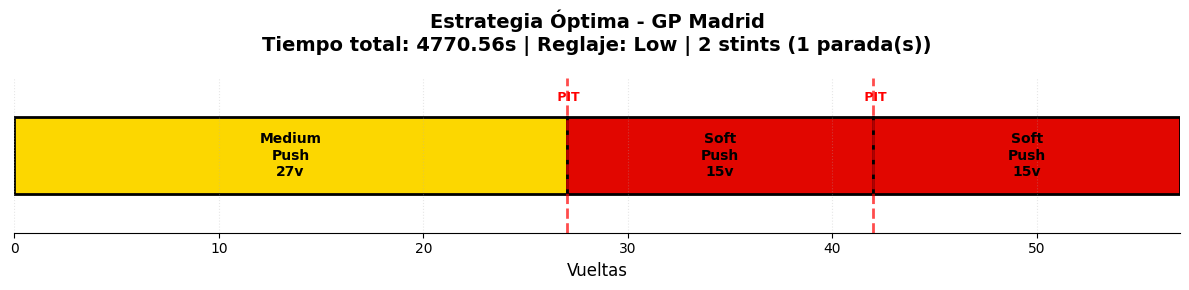

 Visualización generada


In [26]:
# ==========================================
# Visualización: Diagrama de stints
# ==========================================

if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    
    import matplotlib.pyplot as plt
    
    # Colores oficiales de neumáticos F1
    colors = {
        'Soft': '#e10600',    # Rojo
        'Medium': '#fcd700',  # Amarillo
        'Hard': '#ffffff',    # Blanco
        'Inter': '#39b54a'    # Verde
    }
    
    # Preparar datos para visualización
    stints_plot = []
    start = 0
    
    for info in stints_info:
        stints_plot.append({
            'start': start,
            'length': info['Vueltas'],
            'compound': info['Compuesto'],
            'mode': info['Modo']
        })
        start += info['Vueltas']
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 3))
    
    # Dibujar cada stint
    for stint in stints_plot:
        ax.barh(
            y=0,
            width=stint['length'],
            left=stint['start'],
            height=0.5,
            color=colors[stint['compound']],
            edgecolor='black',
            linewidth=2
        )
        
        # Etiqueta dentro del stint
        mid_point = stint['start'] + stint['length'] / 2
        ax.text(
            mid_point,
            0,
            f"{stint['compound']}\n{stint['mode']}\n{stint['length']:.0f}v",
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color='black'
        )
    
    # Configurar ejes
    ax.set_xlim(0, 57)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Vueltas', fontsize=12)
    ax.set_title(
        f'Estrategia Óptima - GP Madrid\n'
        f'Tiempo total: {pyo.value(model.T_total):.2f}s | '
        f'Reglaje: {reglaje} | '
        f'{n_stints} stints ({n_paradas} parada(s))',
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    
    # Marcar paradas en boxes
    parada_pos = 0
    for i, info in enumerate(stints_info[:-1]):  # Todas menos la última
        parada_pos += info['Vueltas']
        ax.axvline(
            x=parada_pos,
            color='red',
            linestyle='--',
            linewidth=2,
            alpha=0.7
        )
        ax.text(
            parada_pos,
            0.35,
            ' PIT',
            ha='center',
            fontsize=9,
            color='red',
            fontweight='bold'
        )
    
    # Estética
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(axis='x', alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    plt.show()
    
    print(" Visualización generada")

from IPython.display import display, HTML


html_code = """
<div style="display: flex; justify-content: center; margin: 0; padding: 0;">
    <img src="imagenes/imagen3.jpg" style="max-width: 55%; height: auto; border: none;">
</div>
"""

display(HTML(html_code))

La Figura muestra la estrategia óptima y distintos escenarios de carrera, acompañados por una representación visual de los compuestos de neumáticos utilizados, facilitando la interpretación cualitativa de las decisiones estratégicas del modelo. Siendo el blanco el neumatico duro, el amarillo el neumatico medio y el rojo el neumatico blando


In [27]:
# ==========================================
# Verificación de factibilidad de la solución
# ==========================================

if results.solver.termination_condition == pyo.TerminationCondition.optimal:
    
    print("\n" + "="*70)
    print("VERIFICACIÓN DE FACTIBILIDAD")
    print("="*70)
    
    verificaciones = []
    
    # 1. Cobertura de vueltas
    vueltas_totales = sum(info['Vueltas'] for info in stints_info)
    check_vueltas = abs(vueltas_totales - 57) < 0.01
    verificaciones.append(("Vueltas totales = 57", check_vueltas, f"{vueltas_totales:.1f}"))
    
    # 2. Mínimo 2 stints
    check_stints = n_stints >= 2
    verificaciones.append(("Mínimo 2 stints", check_stints, f"{n_stints}"))
    
    # 3. Vida máxima de neumáticos
    for info in stints_info:
        vida_max = pyo.value(model.VidaMax[info['Compuesto']])
        check_vida = info['Vueltas'] <= vida_max
        verificaciones.append(
            (f"Vida {info['Compuesto']} stint {info['Stint']}", 
             check_vida, 
             f"{info['Vueltas']:.1f} ≤ {vida_max}")
        )
    
    # 4. Stock de neumáticos
    for c in ['Soft', 'Medium', 'Hard']:
        uso = sum(1 for info in stints_info if info['Compuesto'] == c)
        stock = pyo.value(model.Stock[c])
        check_stock = uso <= stock
        verificaciones.append(
            (f"Stock {c}", check_stock, f"{uso} ≤ {stock}")
        )
    
    # 5. Un reglaje global
    reglajes_activos = sum(1 for r in model.R if pyo.value(model.w[r]) > 0.5)
    check_reglaje = reglajes_activos == 1
    verificaciones.append(("Un reglaje único", check_reglaje, f"{reglajes_activos}"))
    
    # Mostrar resultados
    print("\n")
    for nombre, passed, detalle in verificaciones:
        simbolo = "✅" if passed else "❌"
        print(f"{simbolo} {nombre:35s} → {detalle}")
    
    # Resumen
    todo_ok = all(v[1] for v in verificaciones)
    
    print("\n" + "="*70)
    if todo_ok:
        print(" TODAS LAS VERIFICACIONES PASADAS")
        print("   La solución es factible y cumple todas las restricciones")
    else:
        print(" ALGUNAS VERIFICACIONES FALLARON")
        print("   Revisar el modelo o los parámetros")
    print("="*70)


VERIFICACIÓN DE FACTIBILIDAD


✅ Vueltas totales = 57                → 57.0
✅ Mínimo 2 stints                     → 2
✅ Vida Medium stint 1                 → 27.0 ≤ 28
✅ Vida Soft stint 2                   → 15.0 ≤ 15
✅ Vida Soft stint 3                   → 15.0 ≤ 15
✅ Stock Soft                          → 2 ≤ 2
✅ Stock Medium                        → 1 ≤ 2
✅ Stock Hard                          → 0 ≤ 1
✅ Un reglaje único                    → 1

 TODAS LAS VERIFICACIONES PASADAS
   La solución es factible y cumple todas las restricciones


---

<a id="seccion-8"></a>

## 8. Análisis de Dualidad y Precios Sombra

En esta sección analizamos el valor económico de las restricciones del modelo mediante el estudio de las **variables duales** (precios sombra). Este análisis permite responder preguntas como:

- ¿Cuánto valor tendría disponer de 1 vuelta adicional de vida del neumático Soft?
- ¿Cuál es el impacto marginal de reducir el tiempo de parada en boxes?
- ¿Qué restricciones están "activas" y limitan la solución óptima?

### 8.1 Fundamentos teóricos

Para un problema de optimización de la forma:

$$\min_{x} f(x)$$
$$\text{s.a. } g_i(x) \leq b_i, \quad i = 1, \ldots, m$$

El **precio sombra** (o multiplicador de Lagrange) $\lambda_i$ asociado a la restricción $i$ indica:

$$\lambda_i = \frac{\partial f^*}{\partial b_i}$$

Es decir, el cambio en el valor óptimo de la función objetivo por cada unidad de relajación del lado derecho de la restricción.

**Interpretación:**
- $\lambda_i > 0$: La restricción está activa y limita la solución. Relajarla mejoraría el objetivo.
- $\lambda_i = 0$: La restricción no está activa (tiene holgura). Relajarla no afecta la solución.


In [28]:
# ==========================================
# Configuración para análisis de dualidad
# ==========================================

# NOTA: Para problemas MINLP, los precios sombra no están definidos
# de la misma forma que en LP. Realizaremos un análisis de sensibilidad
# paramétrico que nos da información equivalente.

# Guardar la solución óptima base
T_optimo_base = pyo.value(model.T_total)
print(f"Tiempo óptimo base: {T_optimo_base:.2f} segundos")

# Estrategia óptima base
estrategia_base = []
for s in model.S:
    if pyo.value(model.y[s]) > 0.5:
        l_val = pyo.value(model.l[s])
        compuesto = next(c for c in model.C if pyo.value(model.x[s, c]) > 0.5)
        modo = next(m for m in model.M if pyo.value(model.z[s, m]) > 0.5)
        estrategia_base.append({'stint': s, 'vueltas': l_val, 'compuesto': compuesto, 'modo': modo})

print(f"\nEstrategia base: {len(estrategia_base)} stints")
for e in estrategia_base:
    print(f"  Stint {e['stint']}: {e['compuesto']} ({e['vueltas']:.0f} vueltas) - {e['modo']}")

Tiempo óptimo base: 4770.56 segundos

Estrategia base: 3 stints
  Stint 1: Medium (27 vueltas) - Push
  Stint 2: Soft (15 vueltas) - Push
  Stint 3: Soft (15 vueltas) - Push


### 8.2 Precio sombra de la vida máxima del neumático

Analizamos cuánto mejoraría el tiempo total si dispusiéramos de 1 vuelta adicional de vida máxima para cada compuesto.

In [29]:
# ==========================================
# Precio sombra: Vida máxima del neumático
# ==========================================

import pandas as pd

# Función para resolver el modelo con parámetros modificados
def resolver_con_vida_modificada(compuesto, delta_vida):
    """Resuelve el modelo aumentando la vida del compuesto en delta_vida vueltas"""
    # Guardar valor original
    vida_original = pyo.value(model.VidaMax[compuesto])
    
    # Modificar parámetro
    model.VidaMax[compuesto] = vida_original + delta_vida
    
    # Resolver silenciosamente
    solver = pyo.SolverFactory("scip")
    results = solver.solve(model, tee=False)
    
    # Obtener nuevo tiempo óptimo
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        T_nuevo = pyo.value(model.T_total)
    else:
        T_nuevo = None
    
    # Restaurar valor original
    model.VidaMax[compuesto] = vida_original
    
    return T_nuevo

# Calcular precio sombra para cada compuesto
print("="*60)
print("ANÁLISIS: Precio sombra de la vida máxima del neumático")
print("="*60)
print(f"\nTiempo óptimo base: {T_optimo_base:.2f}s\n")

resultados_vida = []
delta = 1  # Incremento de 1 vuelta

for c in ['Soft', 'Medium', 'Hard']:
    vida_actual = pyo.value(model.VidaMax[c])
    T_nuevo = resolver_con_vida_modificada(c, delta)
    
    if T_nuevo:
        mejora = T_optimo_base - T_nuevo
        precio_sombra = mejora / delta
        resultados_vida.append({
            'Compuesto': c,
            'Vida actual': vida_actual,
            'Vida +1': vida_actual + delta,
            'T_nuevo (s)': T_nuevo,
            'Mejora (s)': mejora,
            'Precio sombra (s/vuelta)': precio_sombra
        })
        print(f"{c}:")
        print(f"  Vida actual: {vida_actual} vueltas → Vida +1: {vida_actual + delta} vueltas")
        print(f"  Tiempo nuevo: {T_nuevo:.2f}s")
        print(f"  Mejora: {mejora:.2f}s")
        print(f"  → Precio sombra: {precio_sombra:.2f} segundos/vuelta adicional")
        print()

# Mostrar tabla resumen
df_vida = pd.DataFrame(resultados_vida)
print("\n" + "="*60)
print("TABLA RESUMEN: Precios sombra de vida máxima")
print("="*60)
print(df_vida.to_string(index=False))

# Interpretación
max_precio = df_vida.loc[df_vida['Precio sombra (s/vuelta)'].idxmax()]
print(f"\n💡 INTERPRETACIÓN:")
print(f"   El compuesto con mayor precio sombra es {max_precio['Compuesto']}")
print(f"   → Cada vuelta adicional de vida del {max_precio['Compuesto']} reduce")
print(f"     el tiempo total en {max_precio['Precio sombra (s/vuelta)']:.2f} segundos")

ANÁLISIS: Precio sombra de la vida máxima del neumático

Tiempo óptimo base: 4770.56s

Soft:
  Vida actual: 15 vueltas → Vida +1: 16 vueltas
  Tiempo nuevo: 4759.61s
  Mejora: 10.96s
  → Precio sombra: 10.96 segundos/vuelta adicional

Medium:
  Vida actual: 28 vueltas → Vida +1: 29 vueltas
  Tiempo nuevo: 4770.56s
  Mejora: -0.00s
  → Precio sombra: -0.00 segundos/vuelta adicional

Hard:
  Vida actual: 42 vueltas → Vida +1: 43 vueltas
  Tiempo nuevo: 4770.56s
  Mejora: -0.00s
  → Precio sombra: -0.00 segundos/vuelta adicional


TABLA RESUMEN: Precios sombra de vida máxima
Compuesto  Vida actual  Vida +1  T_nuevo (s)    Mejora (s)  Precio sombra (s/vuelta)
     Soft           15       16  4759.609996  1.095500e+01              1.095500e+01
   Medium           28       29  4770.565000 -1.827029e-07             -1.827029e-07
     Hard           42       43  4770.565000 -1.827029e-07             -1.827029e-07

💡 INTERPRETACIÓN:
   El compuesto con mayor precio sombra es Soft
   → Cada vuel

### 8.3 Precio sombra del tiempo de parada en boxes

Analizamos la sensibilidad del tiempo total respecto al tiempo de parada en boxes. Esto nos indica el valor de mejorar la eficiencia del equipo de mecánicos.

In [30]:
# ==========================================
# Precio sombra: Tiempo de parada en boxes
# ==========================================

def resolver_con_tiempo_parada(nuevo_p_stint):
    """Resuelve el modelo con un nuevo tiempo de parada"""
    p_original = pyo.value(model.P_stint)
    model.P_stint = nuevo_p_stint
    
    solver = pyo.SolverFactory("scip")
    results = solver.solve(model, tee=False)
    
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        T_nuevo = pyo.value(model.T_total)
        n_paradas = sum(1 for s in model.S if pyo.value(model.y[s]) > 0.5) - 1
    else:
        T_nuevo = None
        n_paradas = None
    
    model.P_stint = p_original
    return T_nuevo, n_paradas

# Evaluar rango de tiempos de parada
print("="*60)
print("ANÁLISIS: Sensibilidad al tiempo de parada")
print("="*60)

p_stint_base = pyo.value(model.P_stint)
tiempos_parada = [20, 25, 28, 30, 32, 35, 38, 40, 45, 50]

resultados_parada = []
for p in tiempos_parada:
    T_nuevo, n_paradas = resolver_con_tiempo_parada(p)
    if T_nuevo:
        resultados_parada.append({
            'P_stint (s)': p,
            'T_total (s)': T_nuevo,
            'Paradas': n_paradas,
            'Diferencia vs base': T_nuevo - T_optimo_base
        })

df_parada = pd.DataFrame(resultados_parada)
print(f"\nTiempo de parada base: {p_stint_base:.0f}s")
print(f"Tiempo óptimo base: {T_optimo_base:.2f}s\n")
print(df_parada.to_string(index=False))

# Calcular precio sombra (derivada numérica)
# dT/dP ≈ (T(P+1) - T(P-1)) / 2
T_mas, _ = resolver_con_tiempo_parada(p_stint_base + 1)
T_menos, _ = resolver_con_tiempo_parada(p_stint_base - 1)
precio_sombra_parada = (T_mas - T_menos) / 2

print(f"\n PRECIO SOMBRA DEL TIEMPO DE PARADA:")
print(f"   dT_total/dP_stint ≈ {precio_sombra_parada:.2f}")
print(f"   → Reducir el tiempo de parada en 1 segundo mejora")
print(f"     el tiempo total en {abs(precio_sombra_parada):.2f} segundos")

ANÁLISIS: Sensibilidad al tiempo de parada

Tiempo de parada base: 32s
Tiempo óptimo base: 4770.56s

 P_stint (s)  T_total (s)  Paradas  Diferencia vs base
          20  4746.564996        2          -24.000004
          25  4756.565000        2          -14.000000
          28  4762.565000        2           -8.000000
          30  4766.564997        2           -4.000003
          32  4770.565000        2            0.000000
          35  4776.565000        2            6.000000
          38  4782.564991        2           11.999991
          40  4786.564998        2           15.999998
          45  4796.565000        2           26.000000
          50  4806.565000        2           36.000000

 PRECIO SOMBRA DEL TIEMPO DE PARADA:
   dT_total/dP_stint ≈ 2.00
   → Reducir el tiempo de parada en 1 segundo mejora
     el tiempo total en 2.00 segundos


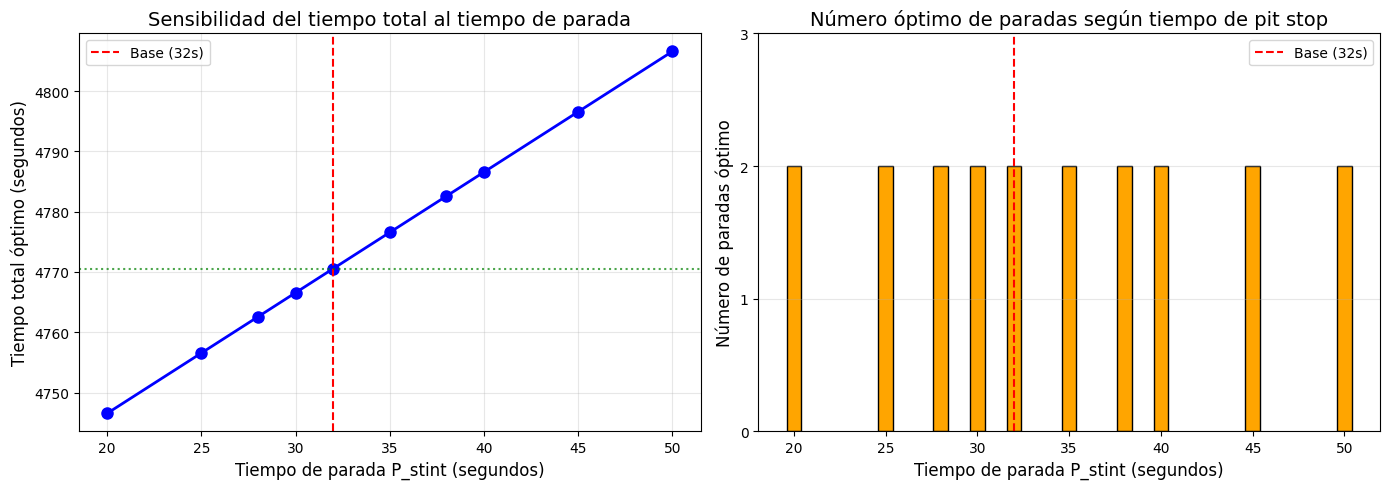


 INTERPRETACIÓN:
   - A menor tiempo de parada, más paradas son óptimas
   - A mayor tiempo de parada, menos paradas son óptimas
   - El modelo ajusta automáticamente la estrategia


In [31]:
# ==========================================
# Visualización: Sensibilidad al tiempo de parada
# ==========================================

import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Tiempo total vs Tiempo de parada
ax1.plot(df_parada['P_stint (s)'], df_parada['T_total (s)'], 'b-o', linewidth=2, markersize=8)
ax1.axvline(x=p_stint_base, color='r', linestyle='--', label=f'Base ({p_stint_base:.0f}s)')
ax1.axhline(y=T_optimo_base, color='g', linestyle=':', alpha=0.7)
ax1.set_xlabel('Tiempo de parada P_stint (segundos)', fontsize=12)
ax1.set_ylabel('Tiempo total óptimo (segundos)', fontsize=12)
ax1.set_title('Sensibilidad del tiempo total al tiempo de parada', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Número de paradas vs Tiempo de parada
colors = ['green' if p == 1 else 'orange' if p == 2 else 'red' for p in df_parada['Paradas']]
ax2.bar(df_parada['P_stint (s)'], df_parada['Paradas'], color=colors, edgecolor='black')
ax2.axvline(x=p_stint_base, color='r', linestyle='--', label=f'Base ({p_stint_base:.0f}s)')
ax2.set_xlabel('Tiempo de parada P_stint (segundos)', fontsize=12)
ax2.set_ylabel('Número de paradas óptimo', fontsize=12)
ax2.set_title('Número óptimo de paradas según tiempo de pit stop', fontsize=14)
ax2.set_yticks([0, 1, 2, 3])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n INTERPRETACIÓN:")
print("   - A menor tiempo de parada, más paradas son óptimas")
print("   - A mayor tiempo de parada, menos paradas son óptimas")
print("   - El modelo ajusta automáticamente la estrategia")

### 8.4 Análisis de holguras y restricciones activas

Identificamos qué restricciones están **activas** (binding) en la solución óptima y cuáles tienen **holgura**.

In [32]:
# ==========================================
# Análisis de restricciones activas y holguras
# ==========================================

print("="*70)
print("ANÁLISIS DE RESTRICCIONES ACTIVAS Y HOLGURAS")
print("="*70)

# Restaurar la solución óptima base
solver = pyo.SolverFactory("scip")
solver.solve(model, tee=False)

print("\n📌 RESTRICCIONES DE VIDA MÁXIMA DEL NEUMÁTICO:")
print("-" * 50)
for s in model.S:
    if pyo.value(model.y[s]) > 0.5:
        l_val = pyo.value(model.l[s])
        compuesto = next(c for c in model.C if pyo.value(model.x[s, c]) > 0.5)
        vida_max = pyo.value(model.VidaMax[compuesto])
        holgura = vida_max - l_val
        estado = "🔴 ACTIVA" if holgura < 0.5 else f"🟢 Holgura: {holgura:.1f} vueltas"
        print(f"  Stint {s}: {compuesto} - {l_val:.0f}/{vida_max} vueltas → {estado}")

print("\n📌 RESTRICCIÓN DE STOCK DE NEUMÁTICOS:")
print("-" * 50)
for c in ['Soft', 'Medium', 'Hard']:
    uso = sum(1 for s in model.S if pyo.value(model.x[s, c]) > 0.5)
    stock = pyo.value(model.Stock[c])
    holgura = stock - uso
    estado = "🔴 ACTIVA" if holgura == 0 else f"🟢 Holgura: {holgura} juegos"
    print(f"  {c}: {uso}/{stock} juegos usados → {estado}")

print("\n📌 RESTRICCIÓN DE MÍNIMO 2 STINTS (1 parada):")
print("-" * 50)
n_stints = sum(1 for s in model.S if pyo.value(model.y[s]) > 0.5)
holgura = n_stints - 2
estado = "🔴 ACTIVA (mínimo obligatorio)" if holgura == 0 else f"🟢 Holgura: {holgura} stints extra"
print(f"  Stints activos: {n_stints} → {estado}")

print("\n📌 RESTRICCIÓN DE COBERTURA TOTAL (57 vueltas):")
print("-" * 50)
total_vueltas = sum(pyo.value(model.l[s]) for s in model.S)
print(f"  Vueltas cubiertas: {total_vueltas:.0f}/57 → 🔴 ACTIVA (igualdad)")

print("\n" + "="*70)
print("RESUMEN DE INTERPRETACIÓN")
print("="*70)
print("""
Las restricciones ACTIVAS (🔴) son las que limitan la solución óptima:
  - Si se relajaran, el tiempo total podría mejorar
  - Son las más importantes para el rendimiento del modelo

Las restricciones con HOLGURA (🟢) no limitan la solución:
  - Modificarlas no afectaría el resultado óptimo
  - Son restricciones "no binding"
""")

ANÁLISIS DE RESTRICCIONES ACTIVAS Y HOLGURAS

📌 RESTRICCIONES DE VIDA MÁXIMA DEL NEUMÁTICO:
--------------------------------------------------
  Stint 1: Medium - 27/28 vueltas → 🟢 Holgura: 1.0 vueltas
  Stint 2: Soft - 15/15 vueltas → 🔴 ACTIVA
  Stint 3: Soft - 15/15 vueltas → 🔴 ACTIVA

📌 RESTRICCIÓN DE STOCK DE NEUMÁTICOS:
--------------------------------------------------
  Soft: 2/2 juegos usados → 🔴 ACTIVA
  Medium: 1/2 juegos usados → 🟢 Holgura: 1 juegos
  Hard: 0/1 juegos usados → 🟢 Holgura: 1 juegos

📌 RESTRICCIÓN DE MÍNIMO 2 STINTS (1 parada):
--------------------------------------------------
  Stints activos: 3 → 🟢 Holgura: 1 stints extra

📌 RESTRICCIÓN DE COBERTURA TOTAL (57 vueltas):
--------------------------------------------------
  Vueltas cubiertas: 57/57 → 🔴 ACTIVA (igualdad)

RESUMEN DE INTERPRETACIÓN

Las restricciones ACTIVAS (🔴) son las que limitan la solución óptima:
  - Si se relajaran, el tiempo total podría mejorar
  - Son las más importantes para el rendimie

### 8.5 Condiciones de Karush-Kuhn-Tucker (KKT)

Las condiciones KKT son las condiciones necesarias de optimalidad para problemas de optimización no lineales. Para nuestro modelo, en la solución óptima se cumplen:
1. **Condición de factibilidad**
    1. **Factibilidad primal**: Todas las restricciones se satisfacen
    2. **Factibilidad dual**: $\lambda_i \geq 0$ para restricciones de desigualdad
2. **Holgura complementaria**: $\lambda_i \cdot g_i(x^*) = 0$
3. **Condición de estacionariedad**: $\nabla f(x^*) = \sum_i \lambda_i \nabla g_i(x^*)$

**Nota**: En problemas MINLP (con variables enteras), las condiciones KKT no aplican directamente, pero el análisis de sensibilidad proporciona información equivalente sobre el valor marginal de las restricciones.

In [33]:
# ==========================================
# Resumen: Tabla de precios sombra
# ==========================================

print("="*70)
print("TABLA RESUMEN DE PRECIOS SOMBRA (ANÁLISIS DE SENSIBILIDAD)")
print("="*70)

# Crear tabla resumen
resumen = pd.DataFrame([
    {'Parámetro': 'Vida máxima Soft', 'Valor base': '15 vueltas', 
     'Precio sombra': f"{df_vida[df_vida['Compuesto']=='Soft']['Precio sombra (s/vuelta)'].values[0]:.2f} s/vuelta",
     'Interpretación': 'Cada vuelta extra reduce el tiempo total'},
    {'Parámetro': 'Vida máxima Medium', 'Valor base': '28 vueltas',
     'Precio sombra': f"{df_vida[df_vida['Compuesto']=='Medium']['Precio sombra (s/vuelta)'].values[0]:.2f} s/vuelta",
     'Interpretación': 'Cada vuelta extra reduce el tiempo total'},
    {'Parámetro': 'Vida máxima Hard', 'Valor base': '42 vueltas',
     'Precio sombra': f"{df_vida[df_vida['Compuesto']=='Hard']['Precio sombra (s/vuelta)'].values[0]:.2f} s/vuelta",
     'Interpretación': 'Cada vuelta extra reduce el tiempo total'},
    {'Parámetro': 'Tiempo de parada', 'Valor base': f'{p_stint_base:.0f} segundos',
     'Precio sombra': f"{abs(precio_sombra_parada):.2f} s/s",
     'Interpretación': 'Cada segundo menos de parada mejora el tiempo'},
])

print(resumen.to_string(index=False))

print("\n" + "="*70)
print("CONCLUSIONES DEL ANÁLISIS DE DUALIDAD")
print("="*70)
print("""
1. El análisis de precios sombra permite cuantificar el valor de mejorar
   cada aspecto del vehículo o la estrategia.

2. Los equipos de F1 pueden usar esta información para priorizar:
   - Desarrollo de neumáticos más duraderos
   - Mejora de la eficiencia en boxes
   - Optimización del reglaje aerodinámico

3. El precio sombra más alto indica dónde invertir recursos para
   obtener el mayor beneficio en tiempo de carrera.
""")

TABLA RESUMEN DE PRECIOS SOMBRA (ANÁLISIS DE SENSIBILIDAD)
         Parámetro  Valor base  Precio sombra                                Interpretación
  Vida máxima Soft  15 vueltas 10.96 s/vuelta      Cada vuelta extra reduce el tiempo total
Vida máxima Medium  28 vueltas -0.00 s/vuelta      Cada vuelta extra reduce el tiempo total
  Vida máxima Hard  42 vueltas -0.00 s/vuelta      Cada vuelta extra reduce el tiempo total
  Tiempo de parada 32 segundos       2.00 s/s Cada segundo menos de parada mejora el tiempo

CONCLUSIONES DEL ANÁLISIS DE DUALIDAD

1. El análisis de precios sombra permite cuantificar el valor de mejorar
   cada aspecto del vehículo o la estrategia.

2. Los equipos de F1 pueden usar esta información para priorizar:
   - Desarrollo de neumáticos más duraderos
   - Mejora de la eficiencia en boxes
   - Optimización del reglaje aerodinámico

3. El precio sombra más alto indica dónde invertir recursos para
   obtener el mayor beneficio en tiempo de carrera.



---

<a id="seccion-9"></a>

## 9. Análisis de Escenarios

En esta sección analizamos cómo diferentes condiciones de carrera afectan a la estrategia óptima. Comparamos cada escenario con las **condiciones normales** (escenario base) para cuantificar el impacto.

### Escenarios considerados:

| Escenario | Descripción | Cambios respecto al base |
|-----------|-------------|-------------------------|
| **Normal** | Condiciones estándar | Referencia |
| **Calor Extremo** | Temperatura >35°C | +2% tiempo/vuelta, +50% degradación, -25% vida neumático |
| **Lluvia** | Lluvia intermitente | +8% tiempo/vuelta, neumáticos Inter disponibles |
| **Safety Car** | SC en vueltas 20-25 | +210s por vueltas lentas, -20s ahorro en parada |

In [34]:
# ==========================================
# FUNCIÓN PARA RESOLVER ESCENARIOS
# ==========================================

def resolver_escenario(escenario_nombre, factor_tiempo=1.0, factor_degradacion=1.0, 
                       vida_factor=1.0, lluvia=False, safety_car=False, virtual_safety_car=False,
                       sc_vueltas=6, tiempo_vuelta_sc=120.0, ahorro_parada_sc=20.0,
                       vsc_vueltas=3, tiempo_vuelta_vsc=100.0, ahorro_parada_vsc=12.0):
    """
    Resuelve el modelo para un escenario específico.
    
    IMPORTANTE: Los parámetros base coinciden con el modelo original:
    - T_base: Soft/Push=80s, Medium/Push=85.5s, Hard/Push=90s
    - alpha: Soft=0.035, Medium=0.020, Hard=0.010
    - VidaMax: Soft=15, Medium=28, Hard=42
    - P_stint: 32s
    
    Returns:
        dict: Resultados incluyendo tiempo, estrategia y comparación con base
    """
    import pyomo.environ as pyo
    
    m = pyo.ConcreteModel()
    
    # Conjuntos
    S_max = 4
    m.S = pyo.RangeSet(1, S_max)
    
    if lluvia:
        m.C = pyo.Set(initialize=['Soft', 'Medium', 'Hard', 'Inter'])
    else:
        m.C = pyo.Set(initialize=['Soft', 'Medium', 'Hard'])
    
    m.M = pyo.Set(initialize=['Push', 'Balanced', 'Save'])
    m.R = pyo.Set(initialize=['Low', 'Balanced', 'High'])
    
    # Parámetros (IGUALES AL MODELO ORIGINAL)
    m.L = pyo.Param(initialize=57)
    m.P_stint = pyo.Param(initialize=32.0)
    m.l_min = pyo.Param(initialize=1)
    m.gamma_deg = pyo.Param(initialize=0.5)
    
    # Tiempos base ajustados (IGUALES AL MODELO ORIGINAL)
    T_base_data = {
        ('Soft', 'Push'): 80.0 * factor_tiempo,
        ('Soft', 'Balanced'): 83.5 * factor_tiempo,
        ('Soft', 'Save'): 87.0 * factor_tiempo,
        ('Medium', 'Push'): 85.5 * factor_tiempo,
        ('Medium', 'Balanced'): 89.0 * factor_tiempo,
        ('Medium', 'Save'): 92.5 * factor_tiempo,
        ('Hard', 'Push'): 90.0 * factor_tiempo,
        ('Hard', 'Balanced'): 93.5 * factor_tiempo,
        ('Hard', 'Save'): 97.0 * factor_tiempo,
    }
    
    if lluvia:
        # Inter en lluvia (del modelo original)
        T_base_data[('Inter', 'Push')] = 98.0 * factor_tiempo
        T_base_data[('Inter', 'Balanced')] = 103.0 * factor_tiempo
        T_base_data[('Inter', 'Save')] = 106.0 * factor_tiempo
        # Los slicks son muy lentos en lluvia (+15%)
        for c in ['Soft', 'Medium', 'Hard']:
            for mo in ['Push', 'Balanced', 'Save']:
                T_base_data[(c, mo)] *= 1.15
    
    m.T_base = pyo.Param(m.C, m.M, initialize=T_base_data)
    
    # Degradación ajustada (IGUALES AL MODELO ORIGINAL)
    alpha_data = {
        'Soft': 0.035 * factor_degradacion,    # Era 0.012, ahora 0.035
        'Medium': 0.020 * factor_degradacion,  # Era 0.007, ahora 0.020
        'Hard': 0.010 * factor_degradacion,    # Era 0.004, ahora 0.010
    }
    if lluvia:
        alpha_data['Inter'] = 0.015 * factor_degradacion
    m.alpha = pyo.Param(m.C, initialize=alpha_data)
    
    # Vida máxima ajustada (IGUALES AL MODELO ORIGINAL)
    VidaMax_data = {
        'Soft': int(15 * vida_factor),   # Igual
        'Medium': int(28 * vida_factor), # Era 25, ahora 28
        'Hard': int(42 * vida_factor),   # Era 35, ahora 42
    }
    if lluvia:
        VidaMax_data['Inter'] = int(27 * vida_factor)
    m.VidaMax = pyo.Param(m.C, initialize=VidaMax_data)
    
    m.delta_setup = pyo.Param(m.R, initialize={'Low': -0.1, 'Balanced': 0.0, 'High': 0.1})
    
    # Variables
    m.y = pyo.Var(m.S, domain=pyo.Binary)
    m.l = pyo.Var(m.S, domain=pyo.NonNegativeReals, bounds=(0, 57))
    m.x = pyo.Var(m.S, m.C, domain=pyo.Binary)
    m.z = pyo.Var(m.S, m.M, domain=pyo.Binary)
    m.w = pyo.Var(m.R, domain=pyo.Binary)
    m.D = pyo.Var(m.S, domain=pyo.NonNegativeReals)
    m.T = pyo.Var(m.S, domain=pyo.NonNegativeReals)
    m.T_total = pyo.Var(domain=pyo.NonNegativeReals)
    
    # Restricciones
    m.total_laps = pyo.Constraint(expr=sum(m.l[s] for s in m.S) == m.L)
    
    def stint_activation(model, s):
        return model.l[s] <= model.L * model.y[s]
    m.stint_act = pyo.Constraint(m.S, rule=stint_activation)
    
    def one_compound(model, s):
        return sum(model.x[s, c] for c in model.C) == model.y[s]
    m.one_comp = pyo.Constraint(m.S, rule=one_compound)
    
    def one_mode(model, s):
        return sum(model.z[s, mo] for mo in model.M) == model.y[s]
    m.one_mod = pyo.Constraint(m.S, rule=one_mode)
    
    m.one_setup = pyo.Constraint(expr=sum(m.w[r] for r in m.R) == 1)
    m.min_stints = pyo.Constraint(expr=sum(m.y[s] for s in m.S) >= 2)
    
    def vida_max_rule(model, s, c):
        return model.l[s] <= model.VidaMax[c] + model.L * (1 - model.x[s, c])
    m.vida_max = pyo.Constraint(m.S, m.C, rule=vida_max_rule)
    
    def degradation_rule(model, s):
        return model.D[s] == sum(model.alpha[c] * model.l[s]**2 * model.x[s, c] for c in model.C)
    m.deg_rule = pyo.Constraint(m.S, rule=degradation_rule)
    
    def stint_time_rule(model, s):
        return model.T[s] == (
            sum(model.T_base[c, mo] * model.l[s] * model.x[s, c] * model.z[s, mo] 
                for c in model.C for mo in model.M)
            + model.D[s] * model.l[s] * model.gamma_deg
            + sum(model.delta_setup[r] * model.l[s] * model.w[r] for r in model.R)
        )
    m.stint_time = pyo.Constraint(m.S, rule=stint_time_rule)
    
    # Calcular tiempo extra según el escenario
    tiempo_extra_evento = 0.0
    ahorro_evento = 0.0
    
    if safety_car:
        tiempo_vuelta_normal = 85.0
        tiempo_extra_evento = sc_vueltas * (tiempo_vuelta_sc - tiempo_vuelta_normal)
        ahorro_evento = ahorro_parada_sc
    elif virtual_safety_car:
        tiempo_vuelta_normal = 85.0
        tiempo_extra_evento = vsc_vueltas * (tiempo_vuelta_vsc - tiempo_vuelta_normal)
        ahorro_evento = ahorro_parada_vsc
    
    def total_time_rule(model):
        return model.T_total == (
            sum(model.T[s] for s in model.S)
            + model.P_stint * (sum(model.y[s] for s in model.S) - 1)
            + tiempo_extra_evento - ahorro_evento
        )
    m.total_time = pyo.Constraint(rule=total_time_rule)
    
    m.obj = pyo.Objective(expr=m.T_total, sense=pyo.minimize)
    
    # Resolver
    solver = pyo.SolverFactory('scip')
    results = solver.solve(m, tee=False)
    
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        estrategia = []
        for s in m.S:
            if pyo.value(m.y[s]) > 0.5:
                compuesto = next(c for c in m.C if pyo.value(m.x[s, c]) > 0.5)
                modo = next(mo for mo in m.M if pyo.value(m.z[s, mo]) > 0.5)
                estrategia.append({
                    'stint': s,
                    'vueltas': pyo.value(m.l[s]),
                    'compuesto': compuesto,
                    'modo': modo,
                    'tiempo': pyo.value(m.T[s]),
                    'degradacion': pyo.value(m.D[s])
                })
        
        reglaje = next(r for r in m.R if pyo.value(m.w[r]) > 0.5)
        
        return {
            'nombre': escenario_nombre,
            'tiempo_total': pyo.value(m.T_total),
            'estrategia': estrategia,
            'n_paradas': len(estrategia) - 1,
            'reglaje': reglaje,
            'vida_max': dict(VidaMax_data),
            'factible': True,
            'tiempo_extra_sc': tiempo_extra_evento if safety_car else 0,
            'ahorro_sc': ahorro_evento if safety_car else 0,
            'tiempo_extra_vsc': tiempo_extra_evento if virtual_safety_car else 0,
            'ahorro_vsc': ahorro_evento if virtual_safety_car else 0
        }
    else:
        return {
            'nombre': escenario_nombre,
            'factible': False
        }

print("Función resolver_escenario definida (parámetros sincronizados con modelo original)")

Función resolver_escenario definida (parámetros sincronizados con modelo original)


---

### 9.1 Escenario Base: Condiciones Normales

Este es el escenario de referencia con condiciones estándar de carrera.

In [35]:
# ==========================================
# ESCENARIO BASE: CONDICIONES NORMALES
# ==========================================

print("="*70)
print("ESCENARIO BASE: CONDICIONES NORMALES")
print("="*70)

resultado_normal = resolver_escenario(
    escenario_nombre='Normal',
    factor_tiempo=1.0,
    factor_degradacion=1.0,
    vida_factor=1.0
)

if resultado_normal['factible']:
    print(f"\n✓ SOLUCIÓN ÓPTIMA ENCONTRADA")
    print(f"\nTiempo total: {resultado_normal['tiempo_total']:.2f} segundos")
    print(f"             ({resultado_normal['tiempo_total']/60:.2f} minutos)")
    print(f"\nNúmero de paradas: {resultado_normal['n_paradas']}")
    print(f"Reglaje aerodinámico: {resultado_normal['reglaje']}")
    
    print(f"\nESTRATEGIA ÓPTIMA:")
    print("-"*50)
    for stint in resultado_normal['estrategia']:
        print(f"  Stint {stint['stint']}: {stint['compuesto']:8s} | "
              f"{stint['vueltas']:5.1f} vueltas | {stint['modo']:10s} | "
              f"Tiempo: {stint['tiempo']:.1f}s")
    print("-"*50)
    
    # Guardar como referencia
    T_BASE = resultado_normal['tiempo_total']
    print(f"\n📌 Este tiempo ({T_BASE:.2f}s) se usará como REFERENCIA para comparar los demás escenarios.")
else:
    print("✗ No se encontró solución factible")

ESCENARIO BASE: CONDICIONES NORMALES

✓ SOLUCIÓN ÓPTIMA ENCONTRADA

Tiempo total: 4852.85 segundos
             (80.88 minutos)

Número de paradas: 3
Reglaje aerodinámico: Low

ESTRATEGIA ÓPTIMA:
--------------------------------------------------
  Stint 1: Soft     |  14.2 vueltas | Push       | Tiempo: 1189.2s
  Stint 2: Soft     |  14.3 vueltas | Push       | Tiempo: 1189.3s
  Stint 3: Soft     |  14.2 vueltas | Push       | Tiempo: 1189.2s
  Stint 4: Soft     |  14.3 vueltas | Push       | Tiempo: 1189.2s
--------------------------------------------------

📌 Este tiempo (4852.85s) se usará como REFERENCIA para comparar los demás escenarios.


---

### 9.2 Escenario: Calor Extremo

**Condiciones:** Temperatura ambiente superior a 35°C

**Efectos:**
- Los neumáticos se degradan un **50% más rápido** (mayor temperatura = mayor desgaste)
- La vida máxima de los neumáticos se reduce un **25%**
- Los tiempos por vuelta aumentan un **2%** (menor agarre)

In [36]:
# ==========================================
# ESCENARIO: CALOR EXTREMO
# ==========================================

print("="*70)
print("ESCENARIO: CALOR EXTREMO (Temperatura > 35°C)")
print("="*70)

resultado_calor = resolver_escenario(
    escenario_nombre='Calor Extremo',
    factor_tiempo=1.02,       # +2% tiempo por vuelta
    factor_degradacion=1.5,   # +50% degradación
    vida_factor=0.75          # -25% vida máxima
)

if resultado_calor['factible']:
    print(f"\n✓ SOLUCIÓN ÓPTIMA ENCONTRADA")
    print(f"\nTiempo total: {resultado_calor['tiempo_total']:.2f} segundos")
    print(f"             ({resultado_calor['tiempo_total']/60:.2f} minutos)")
    print(f"\nNúmero de paradas: {resultado_calor['n_paradas']}")
    
    print(f"\nVida máxima de neumáticos (reducida por calor):")
    for c, v in resultado_calor['vida_max'].items():
        print(f"  {c}: {v} vueltas")
    
    print(f"\nESTRATEGIA ÓPTIMA:")
    print("-"*50)
    for stint in resultado_calor['estrategia']:
        print(f"  Stint {stint['stint']}: {stint['compuesto']:8s} | "
              f"{stint['vueltas']:5.1f} vueltas | {stint['modo']:10s}")
    print("-"*50)
    
    # Comparación con base
    diferencia = resultado_calor['tiempo_total'] - T_BASE
    porcentaje = (diferencia / T_BASE) * 100
    
    print(f"\n📊 COMPARACIÓN CON ESCENARIO BASE:")
    print(f"   Tiempo base (Normal):  {T_BASE:.2f}s")
    print(f"   Tiempo con calor:      {resultado_calor['tiempo_total']:.2f}s")
    print(f"   Diferencia:            +{diferencia:.2f}s (+{porcentaje:.2f}%)")
    print(f"   Paradas adicionales:   {resultado_calor['n_paradas'] - resultado_normal['n_paradas']}")
else:
    print("✗ No se encontró solución factible")

ESCENARIO: CALOR EXTREMO (Temperatura > 35°C)

✓ SOLUCIÓN ÓPTIMA ENCONTRADA

Tiempo total: 5168.51 segundos
             (86.14 minutos)

Número de paradas: 3

Vida máxima de neumáticos (reducida por calor):
  Soft: 11 vueltas
  Medium: 21 vueltas
  Hard: 31 vueltas

ESTRATEGIA ÓPTIMA:
--------------------------------------------------
  Stint 1: Soft     |  11.0 vueltas | Push      
  Stint 2: Medium   |  17.5 vueltas | Push      
  Stint 3: Soft     |  11.0 vueltas | Push      
  Stint 4: Medium   |  17.5 vueltas | Push      
--------------------------------------------------

📊 COMPARACIÓN CON ESCENARIO BASE:
   Tiempo base (Normal):  4852.85s
   Tiempo con calor:      5168.51s
   Diferencia:            +315.65s (+6.50%)
   Paradas adicionales:   0


---

### 9.3 Escenario: Lluvia

**Condiciones:** Lluvia intermitente durante toda la carrera

**Efectos:**
- Los tiempos por vuelta aumentan un **8%** en general
- Los neumáticos **Inter** (intermedios) están disponibles y son más rápidos que los slicks en mojado
- Usar slicks en lluvia añade un **15% adicional** al tiempo (muy peligroso y lento)

In [37]:
# ==========================================
# ESCENARIO: LLUVIA
# ==========================================

print("="*70)
print("ESCENARIO: LLUVIA (Pista mojada)")
print("="*70)

resultado_lluvia = resolver_escenario(
    escenario_nombre='Lluvia',
    factor_tiempo=1.08,       # +8% tiempo base
    factor_degradacion=0.8,   # Menos degradación térmica
    vida_factor=1.0,
    lluvia=True               # Habilita neumáticos Inter
)

if resultado_lluvia['factible']:
    print(f"\n✓ SOLUCIÓN ÓPTIMA ENCONTRADA")
    print(f"\nTiempo total: {resultado_lluvia['tiempo_total']:.2f} segundos")
    print(f"             ({resultado_lluvia['tiempo_total']/60:.2f} minutos)")
    print(f"\nNúmero de paradas: {resultado_lluvia['n_paradas']}")
    
    print(f"\nESTRATEGIA ÓPTIMA:")
    print("-"*50)
    for stint in resultado_lluvia['estrategia']:
        print(f"  Stint {stint['stint']}: {stint['compuesto']:8s} | "
              f"{stint['vueltas']:5.1f} vueltas | {stint['modo']:10s}")
    print("-"*50)
    
    # Verificar uso de Inter
    usa_inter = any(s['compuesto'] == 'Inter' for s in resultado_lluvia['estrategia'])
    if usa_inter:
        print(f"\n🌧️ La estrategia óptima USA neumáticos INTER (intermedios)")
    else:
        print(f"\n⚠️ La estrategia NO usa Inter (slicks son mejores en esta lluvia leve)")
    
    # Comparación con base
    diferencia = resultado_lluvia['tiempo_total'] - T_BASE
    porcentaje = (diferencia / T_BASE) * 100
    
    print(f"\n📊 COMPARACIÓN CON ESCENARIO BASE:")
    print(f"   Tiempo base (Normal):  {T_BASE:.2f}s")
    print(f"   Tiempo con lluvia:     {resultado_lluvia['tiempo_total']:.2f}s")
    print(f"   Diferencia:            +{diferencia:.2f}s (+{porcentaje:.2f}%)")
else:
    print("✗ No se encontró solución factible")

ESCENARIO: LLUVIA (Pista mojada)

✓ SOLUCIÓN ÓPTIMA ENCONTRADA

Tiempo total: 5915.86 segundos
             (98.60 minutos)

Número de paradas: 3

ESTRATEGIA ÓPTIMA:
--------------------------------------------------
  Stint 1: Soft     |  14.2 vueltas | Push      
  Stint 2: Soft     |  14.2 vueltas | Push      
  Stint 3: Soft     |  14.3 vueltas | Push      
  Stint 4: Soft     |  14.3 vueltas | Push      
--------------------------------------------------

⚠️ La estrategia NO usa Inter (slicks son mejores en esta lluvia leve)

📊 COMPARACIÓN CON ESCENARIO BASE:
   Tiempo base (Normal):  4852.85s
   Tiempo con lluvia:     5915.86s
   Diferencia:            +1063.01s (+21.90%)


---

### 9.4 Escenario: Safety Car

**Condiciones:** Safety Car desplegado durante las vueltas 20-25 (6 vueltas)

**Efectos:**
- Durante el SC, todos los coches van **muy lentos** (~120s/vuelta vs ~85s normal)
- Esto añade aproximadamente **+210 segundos** al tiempo total (6 × 35s de penalización)
- **Ventaja:** Si haces una parada durante el SC, pierdes menos tiempo relativo (~20s de ahorro)

**Nota:** El Safety Car siempre hace la carrera más lenta, pero permite optimizar el momento de las paradas.

---
<div style="text-align: center;">
<img src="imagenes/safety.jpg" alt="Safety Car" width="800"/>
<p><em>Safety car en pista tras accidente.</em></p>
</div>

---

In [38]:
# ==========================================
# ESCENARIO: SAFETY CAR
# ==========================================

print("="*70)
print("ESCENARIO: SAFETY CAR (Vueltas 20-25)")
print("="*70)

resultado_sc = resolver_escenario(
    escenario_nombre='Safety Car',
    factor_tiempo=1.0,
    factor_degradacion=1.0,
    vida_factor=1.0,
    safety_car=True,
    sc_vueltas=6,              # 6 vueltas de SC
    tiempo_vuelta_sc=120.0,    # Tiempo por vuelta durante SC
    ahorro_parada_sc=20.0      # Ahorro por parar durante SC
)

if resultado_sc['factible']:
    print(f"\n✓ SOLUCIÓN ÓPTIMA ENCONTRADA")
    print(f"\nTiempo total: {resultado_sc['tiempo_total']:.2f} segundos")
    print(f"             ({resultado_sc['tiempo_total']/60:.2f} minutos)")
    print(f"\nNúmero de paradas: {resultado_sc['n_paradas']}")
    
    print(f"\nDesglose del impacto del Safety Car:")
    print(f"   Penalización por vueltas lentas: +{resultado_sc['tiempo_extra_sc']:.0f}s")
    print(f"   Ahorro por parada durante SC:    -{resultado_sc['ahorro_sc']:.0f}s")
    print(f"   Impacto neto del SC:             +{resultado_sc['tiempo_extra_sc'] - resultado_sc['ahorro_sc']:.0f}s")
    
    print(f"\nESTRATEGIA ÓPTIMA:")
    print("-"*50)
    for stint in resultado_sc['estrategia']:
        print(f"  Stint {stint['stint']}: {stint['compuesto']:8s} | "
              f"{stint['vueltas']:5.1f} vueltas | {stint['modo']:10s}")
    print("-"*50)
    
    # Comparación con base
    diferencia = resultado_sc['tiempo_total'] - T_BASE
    porcentaje = (diferencia / T_BASE) * 100
    
    print(f"\n📊 COMPARACIÓN CON ESCENARIO BASE:")
    print(f"   Tiempo base (Normal):     {T_BASE:.2f}s")
    print(f"   Tiempo con Safety Car:    {resultado_sc['tiempo_total']:.2f}s")
    print(f"   Diferencia:               +{diferencia:.2f}s (+{porcentaje:.2f}%)")
    
    print(f"\n⚠️ NOTA: El Safety Car SIEMPRE hace la carrera más lenta.")
    print(f"   La ventaja es poder optimizar el momento de las paradas.")
else:
    print("✗ No se encontró solución factible")

ESCENARIO: SAFETY CAR (Vueltas 20-25)

✓ SOLUCIÓN ÓPTIMA ENCONTRADA

Tiempo total: 5042.85 segundos
             (84.05 minutos)

Número de paradas: 3

Desglose del impacto del Safety Car:
   Penalización por vueltas lentas: +210s
   Ahorro por parada durante SC:    -20s
   Impacto neto del SC:             +190s

ESTRATEGIA ÓPTIMA:
--------------------------------------------------
  Stint 1: Soft     |  14.2 vueltas | Push      
  Stint 2: Soft     |  14.3 vueltas | Push      
  Stint 3: Soft     |  14.3 vueltas | Push      
  Stint 4: Soft     |  14.3 vueltas | Push      
--------------------------------------------------

📊 COMPARACIÓN CON ESCENARIO BASE:
   Tiempo base (Normal):     4852.85s
   Tiempo con Safety Car:    5042.85s
   Diferencia:               +190.00s (+3.92%)

⚠️ NOTA: El Safety Car SIEMPRE hace la carrera más lenta.
   La ventaja es poder optimizar el momento de las paradas.


---

### 9.5 Escenario: Virtual Safety Car (VSC)

#### ¿Qué es el Virtual Safety Car?

El **Virtual Safety Car (VSC)** es un procedimiento de neutralización de carrera introducido en la Fórmula 1 en 2015. A diferencia del Safety Car tradicional, no hay un coche físico en pista; en su lugar, los pilotos deben reducir su velocidad siguiendo un delta de tiempo mostrado en su volante.


---
<div style="text-align: center;">
<img src="imagenes/vsc.jpg" alt="Virtual Safety Car" width="200"/>
<p><em>Imagen que sale en pantalla cuando aparece un Virtual Safety Car.</em></p>
</div>

---

#### Diferencias entre Safety Car y Virtual Safety Car

| Característica | Safety Car (SC) | Virtual Safety Car (VSC) |
|:---------------|:----------------|:-------------------------|
| **Coche físico** | Sí (Mercedes-AMG GT) | No |
| **Reducción de velocidad** | ~60% (siguen al SC a ~80 km/h) | ~40% (delta de tiempo) |
| **Gaps entre coches** | Se comprimen (todos se agrupan) | Se mantienen |
| **Tiempo por vuelta** | ~120 segundos | ~100 segundos |
| **Duración típica** | 3-6 vueltas | 1-3 vueltas |
| **Adelantamientos** | Prohibidos | Prohibidos |
| **Ventaja de parar** | **ALTA** (~20s ahorro) | **MODERADA** (~12s ahorro) |

#### ¿Cuándo se usa cada uno?

- **Safety Car (SC):** Se despliega en incidentes graves que requieren la presencia de grúas en pista, grandes cantidades de debris, o condiciones peligrosas que necesitan agrupar al pelotón.

- **Virtual Safety Car (VSC):** Se utiliza en incidentes menores donde se necesita reducir la velocidad pero no es necesario agrupar a los coches. Por ejemplo: un monoplaza parado en una zona de escape segura, pequeñas cantidades de debris, o mientras se retira un coche de forma rápida.

#### Impacto estratégico

El VSC ofrece una ventana de pit stop más pequeña que el SC porque:
1. Los coches van más rápido (~100s vs ~120s por vuelta)
2. El ahorro por parar es menor (~12s vs ~20s)
3. Las diferencias de tiempo se mantienen, no se comprimen

**Parámetros del escenario:**
- VSC durante **3 vueltas** (vueltas 20-22)
- Tiempo por vuelta durante VSC: **100 segundos** (vs 85s normal)
- Ahorro por parada durante VSC: **12 segundos**


In [39]:
# ==========================================
# ESCENARIO: VIRTUAL SAFETY CAR (VSC)
# ==========================================

print("="*70)
print("ESCENARIO: VIRTUAL SAFETY CAR (Vueltas 20-22)")
print("="*70)

resultado_vsc = resolver_escenario(
    escenario_nombre='Virtual Safety Car',
    factor_tiempo=1.0,
    factor_degradacion=1.0,
    vida_factor=1.0,
    virtual_safety_car=True,
    vsc_vueltas=3,              # 3 vueltas de VSC
    tiempo_vuelta_vsc=100.0,    # Tiempo por vuelta durante VSC
    ahorro_parada_vsc=12.0      # Ahorro por parar durante VSC
)

if resultado_vsc['factible']:
    print(f"\n✓ SOLUCIÓN ÓPTIMA ENCONTRADA")
    print(f"\nTiempo total: {resultado_vsc['tiempo_total']:.2f} segundos")
    print(f"             ({resultado_vsc['tiempo_total']/60:.2f} minutos)")
    print(f"\nNúmero de paradas: {resultado_vsc['n_paradas']}")
    
    print(f"\nDesglose del impacto del Virtual Safety Car:")
    print(f"   Penalización por vueltas lentas: +{resultado_vsc['tiempo_extra_vsc']:.0f}s")
    print(f"   Ahorro por parada durante VSC:   -{resultado_vsc['ahorro_vsc']:.0f}s")
    print(f"   Impacto neto del VSC:            +{resultado_vsc['tiempo_extra_vsc'] - resultado_vsc['ahorro_vsc']:.0f}s")
    
    print(f"\nESTRATEGIA ÓPTIMA:")
    print("-"*50)
    for stint in resultado_vsc['estrategia']:
        print(f"  Stint {stint['stint']}: {stint['compuesto']:8s} | "
              f"{stint['vueltas']:5.1f} vueltas | {stint['modo']:10s}")
    print("-"*50)
    
    # Comparación con base
    diferencia = resultado_vsc['tiempo_total'] - T_BASE
    porcentaje = (diferencia / T_BASE) * 100
    
    print(f"\n📊 COMPARACIÓN CON ESCENARIO BASE:")
    print(f"   Tiempo base (Normal):         {T_BASE:.2f}s")
    print(f"   Tiempo con Virtual Safety Car:{resultado_vsc['tiempo_total']:.2f}s")
    print(f"   Diferencia:                   +{diferencia:.2f}s (+{porcentaje:.2f}%)")
    
    # Comparación con Safety Car
    if 'resultado_sc' in dir() and resultado_sc['factible']:
        diff_vs_sc = resultado_vsc['tiempo_total'] - resultado_sc['tiempo_total']
        print(f"\n📊 COMPARACIÓN CON SAFETY CAR:")
        print(f"   Tiempo con SC:   {resultado_sc['tiempo_total']:.2f}s")
        print(f"   Tiempo con VSC:  {resultado_vsc['tiempo_total']:.2f}s")
        print(f"   Diferencia:      {diff_vs_sc:.2f}s")
        print(f"\n   → El VSC es {abs(diff_vs_sc):.1f}s más {'rápido' if diff_vs_sc < 0 else 'lento'} que el SC")
        print(f"   → Esto se debe a que el VSC implica vueltas menos lentas")
        print(f"      pero también ofrece menos ventaja al parar")
else:
    print("✗ No se encontró solución factible")

ESCENARIO: VIRTUAL SAFETY CAR (Vueltas 20-22)

✓ SOLUCIÓN ÓPTIMA ENCONTRADA

Tiempo total: 4885.85 segundos
             (81.43 minutos)

Número de paradas: 3

Desglose del impacto del Virtual Safety Car:
   Penalización por vueltas lentas: +45s
   Ahorro por parada durante VSC:   -12s
   Impacto neto del VSC:            +33s

ESTRATEGIA ÓPTIMA:
--------------------------------------------------
  Stint 1: Soft     |  14.2 vueltas | Push      
  Stint 2: Soft     |  14.3 vueltas | Push      
  Stint 3: Soft     |  14.3 vueltas | Push      
  Stint 4: Soft     |  14.3 vueltas | Push      
--------------------------------------------------

📊 COMPARACIÓN CON ESCENARIO BASE:
   Tiempo base (Normal):         4852.85s
   Tiempo con Virtual Safety Car:4885.85s
   Diferencia:                   +33.00s (+0.68%)

📊 COMPARACIÓN CON SAFETY CAR:
   Tiempo con SC:   5042.85s
   Tiempo con VSC:  4885.85s
   Diferencia:      -157.00s

   → El VSC es 157.0s más rápido que el SC
   → Esto se debe a que

---

### 9.5 Comparación de Todos los Escenarios

TABLA COMPARATIVA: TODOS LOS ESCENARIOS


    Escenario Tiempo (s) Tiempo (min)  Paradas Diferencia vs Base                    Estrategia
       Normal    4852.85        80.88        3               0.0s     Soft → Soft → Soft → Soft
Calor Extremo    5168.51        86.14        3            +315.7s Soft → Medium → Soft → Medium
       Lluvia    5915.86        98.60        3           +1063.0s     Soft → Soft → Soft → Soft
   Safety Car    5042.85        84.05        3            +190.0s     Soft → Soft → Soft → Soft


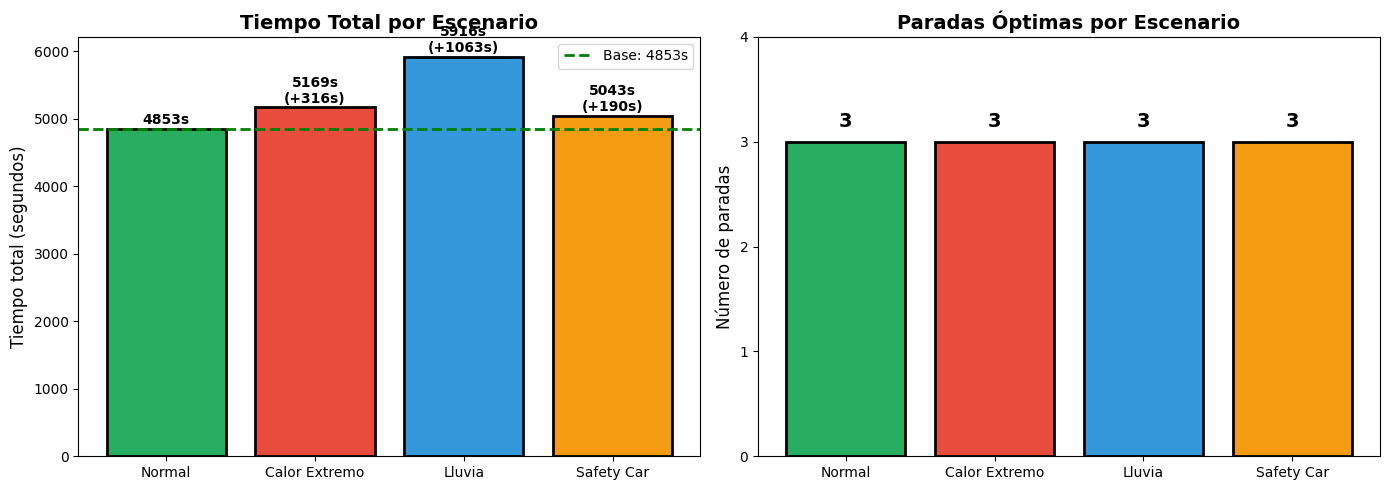


📊 CONCLUSIONES:
   • El escenario más lento es: Lluvia
   • El calor extremo requiere más paradas debido a la mayor degradación
   • El Safety Car añade tiempo pero permite optimizar paradas
   • La lluvia cambia completamente la estrategia de neumáticos


In [40]:
# ==========================================
# TABLA COMPARATIVA DE ESCENARIOS
# ==========================================

import pandas as pd
import matplotlib.pyplot as plt

print("="*70)
print("TABLA COMPARATIVA: TODOS LOS ESCENARIOS")
print("="*70)

# Recopilar resultados
resultados = [resultado_normal, resultado_calor, resultado_lluvia, resultado_sc]

tabla_data = []
for r in resultados:
    if r['factible']:
        estrategia_str = ' → '.join([s['compuesto'] for s in r['estrategia']])
        diferencia = r['tiempo_total'] - T_BASE
        tabla_data.append({
            'Escenario': r['nombre'],
            'Tiempo (s)': f"{r['tiempo_total']:.2f}",
            'Tiempo (min)': f"{r['tiempo_total']/60:.2f}",
            'Paradas': r['n_paradas'],
            'Diferencia vs Base': f"+{diferencia:.1f}s" if diferencia > 0 else f"{diferencia:.1f}s",
            'Estrategia': estrategia_str
        })

df_comparativa = pd.DataFrame(tabla_data)
print("\n")
print(df_comparativa.to_string(index=False))

# Gráfico comparativo
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Tiempos totales
ax1 = axes[0]
nombres = [r['nombre'] for r in resultados if r['factible']]
tiempos = [r['tiempo_total'] for r in resultados if r['factible']]
colores = ['#27ae60', '#e74c3c', '#3498db', '#f39c12']

bars = ax1.bar(nombres, tiempos, color=colores, edgecolor='black', linewidth=2)
ax1.axhline(y=T_BASE, color='green', linestyle='--', linewidth=2, label=f'Base: {T_BASE:.0f}s')
ax1.set_ylabel('Tiempo total (segundos)', fontsize=12)
ax1.set_title('Tiempo Total por Escenario', fontsize=14, fontweight='bold')
ax1.legend()

# Añadir valores sobre las barras
for bar, tiempo in zip(bars, tiempos):
    diff = tiempo - T_BASE
    label = f"{tiempo:.0f}s\n(+{diff:.0f}s)" if diff > 0 else f"{tiempo:.0f}s"
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             label, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 2: Número de paradas
ax2 = axes[1]
paradas = [r['n_paradas'] for r in resultados if r['factible']]
bars2 = ax2.bar(nombres, paradas, color=colores, edgecolor='black', linewidth=2)
ax2.set_ylabel('Número de paradas', fontsize=12)
ax2.set_title('Paradas Óptimas por Escenario', fontsize=14, fontweight='bold')
ax2.set_yticks(range(max(paradas) + 2))

for bar, p in zip(bars2, paradas):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(p), ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 CONCLUSIONES:")
print(f"   • El escenario más lento es: {max(resultados, key=lambda x: x['tiempo_total'] if x['factible'] else 0)['nombre']}")
print(f"   • El calor extremo requiere más paradas debido a la mayor degradación")
print(f"   • El Safety Car añade tiempo pero permite optimizar paradas")
print(f"   • La lluvia cambia completamente la estrategia de neumáticos")

---

<a id="seccion-10"></a>

## 10. Visualizaciones Avanzadas

En esta sección presentamos visualizaciones que facilitan la comprensión de la estrategia óptima y los resultados del análisis.

/var/folders/ts/818xf2p14pbgs4y569ly36980000gn/T/ipykernel_2787/2219394932.py:71: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_patches = [mpatches.Patch(color=c, label=n, edgecolor='black')


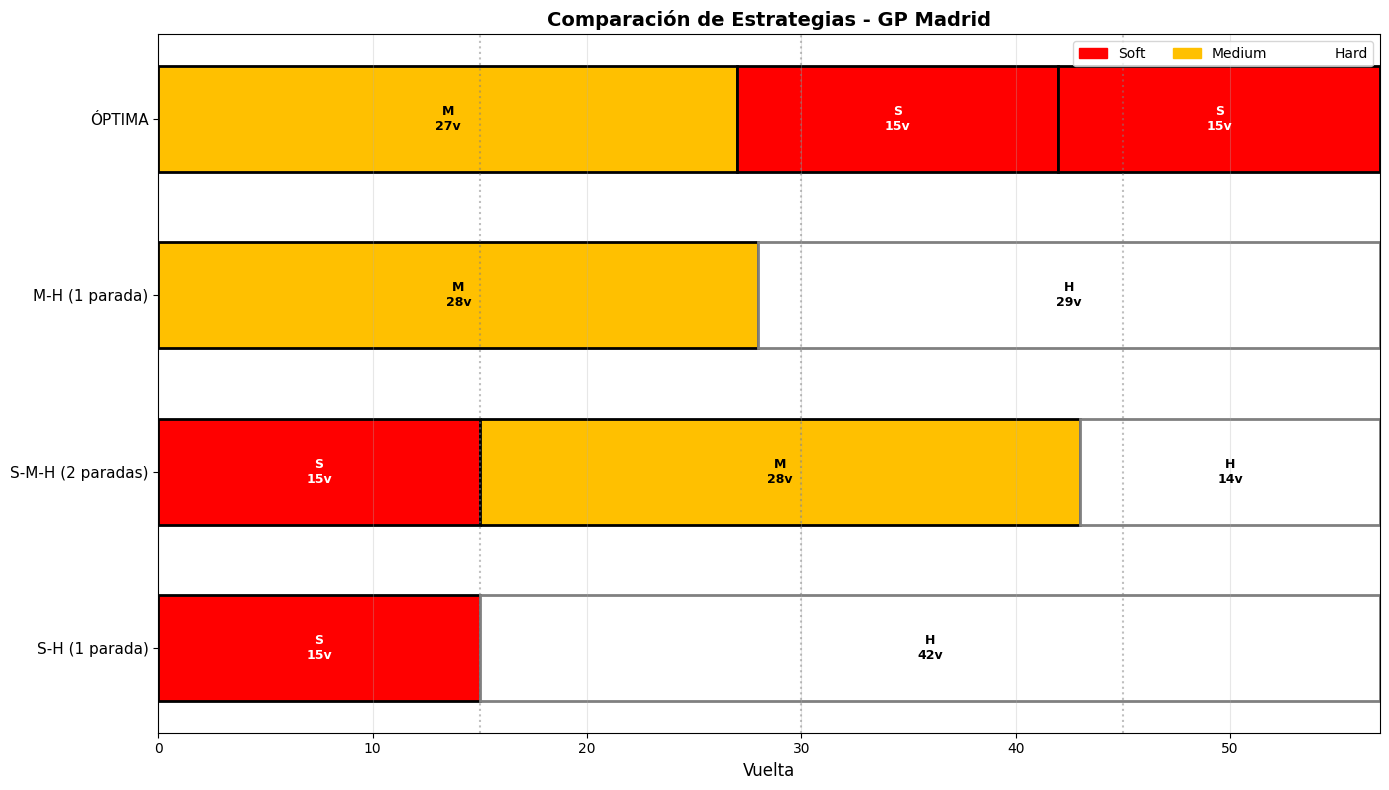


📊 El diagrama muestra cómo se distribuyen los stints a lo largo de la carrera
   S=Soft (rojo), M=Medium (amarillo), H=Hard (blanco)


In [41]:
# ==========================================
# DIAGRAMA DE GANTT DE LA ESTRATEGIA
# ==========================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Colores por compuesto (colores oficiales de F1)
COLORES = {
    'Soft': '#FF0000',      # Rojo
    'Medium': '#FFC000',    # Amarillo
    'Hard': '#FFFFFF',      # Blanco
    'Inter': '#00FF00',     # Verde
}

def diagrama_gantt_estrategia(estrategias_dict, titulo='Comparación de Estrategias'):
    """
    Crea un diagrama de Gantt para visualizar múltiples estrategias.
    
    Args:
        estrategias_dict: Dict con nombre: lista de stints
        titulo: Título del gráfico
    """
    fig, ax = plt.subplots(figsize=(14, len(estrategias_dict) * 1.5 + 2))
    
    y_pos = len(estrategias_dict) - 1
    yticks = []
    ylabels = []
    
    for nombre, estrategia in estrategias_dict.items():
        vuelta_actual = 0
        
        for stint in estrategia:
            compuesto = stint['compuesto']
            vueltas = stint['vueltas']
            modo = stint.get('modo', 'Balanced')
            
            # Dibujar barra
            color = COLORES.get(compuesto, '#808080')
            edgecolor = 'black' if compuesto != 'Hard' else 'gray'
            
            ax.barh(y_pos, vueltas, left=vuelta_actual, height=0.6,
                   color=color, edgecolor=edgecolor, linewidth=2)
            
            # Etiqueta dentro de la barra
            text_color = 'white' if compuesto in ['Soft', 'Inter'] else 'black'
            ax.text(vuelta_actual + vueltas/2, y_pos, 
                   f"{compuesto[0]}\n{vueltas:.0f}v",
                   ha='center', va='center', fontsize=9, fontweight='bold',
                   color=text_color)
            
            vuelta_actual += vueltas
        
        yticks.append(y_pos)
        ylabels.append(nombre)
        y_pos -= 1
    
    # Configurar ejes
    ax.set_xlim(0, 57)
    ax.set_xlabel('Vuelta', fontsize=12)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, fontsize=11)
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    
    # Líneas verticales para marcas importantes
    for v in [15, 30, 45]:
        ax.axvline(x=v, color='gray', linestyle=':', alpha=0.5)
    
    # Leyenda
    legend_patches = [mpatches.Patch(color=c, label=n, edgecolor='black') 
                     for n, c in COLORES.items() if n != 'Inter']
    ax.legend(handles=legend_patches, loc='upper right', ncol=3)
    
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    return fig, ax

# Extraer estrategia óptima del modelo
estrategia_optima = []
for s in model.S:
    if pyo.value(model.y[s]) > 0.5:
        compuesto = next(c for c in model.C if pyo.value(model.x[s, c]) > 0.5)
        modo = next(m for m in model.M if pyo.value(model.z[s, m]) > 0.5)
        estrategia_optima.append({
            'compuesto': compuesto,
            'vueltas': pyo.value(model.l[s]),
            'modo': modo
        })

# Estrategias clásicas para comparar
estrategias = {
    'ÓPTIMA': estrategia_optima,
    'M-H (1 parada)': [
        {'compuesto': 'Medium', 'vueltas': 28},
        {'compuesto': 'Hard', 'vueltas': 29}
    ],
    'S-M-H (2 paradas)': [
        {'compuesto': 'Soft', 'vueltas': 15},
        {'compuesto': 'Medium', 'vueltas': 28},
        {'compuesto': 'Hard', 'vueltas': 14}
    ],
    'S-H (1 parada)': [
        {'compuesto': 'Soft', 'vueltas': 15},
        {'compuesto': 'Hard', 'vueltas': 42}
    ],
}

fig, ax = diagrama_gantt_estrategia(estrategias, 'Comparación de Estrategias - GP Madrid')
plt.show()

print("\n📊 El diagrama muestra cómo se distribuyen los stints a lo largo de la carrera")
print("   S=Soft (rojo), M=Medium (amarillo), H=Hard (blanco)")

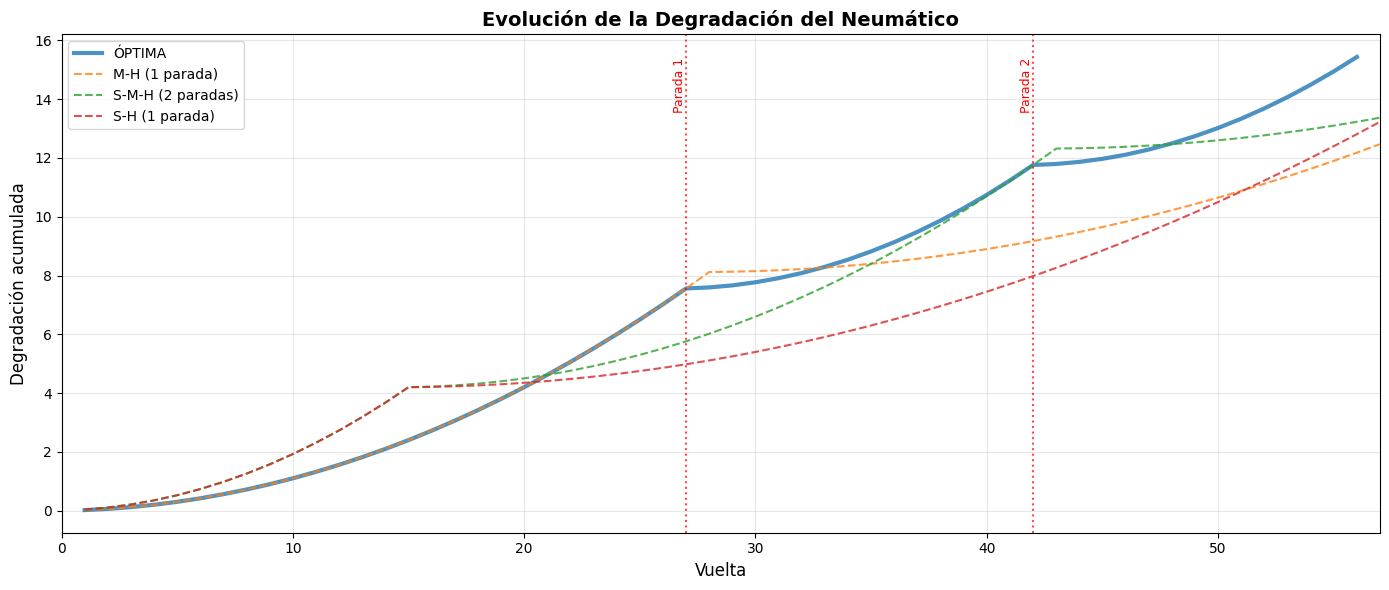


📊 La degradación crece más rápido con compuestos blandos (pendiente mayor)
   Las paradas 'resetean' la tasa de degradación al cambiar neumáticos


In [42]:
# ==========================================
# EVOLUCIÓN DE LA DEGRADACIÓN POR VUELTA
# ==========================================

def simular_degradacion(estrategia):
    """
    Simula la degradación vuelta a vuelta para una estrategia.
    
    Returns:
        tuple: (vueltas, degradacion_acumulada, compuestos_por_vuelta)
    """
    alpha = {'Soft': 0.035, 'Medium': 0.020, 'Hard': 0.010}
    
    vueltas = []
    degradacion = []
    compuestos = []
    
    vuelta_global = 0
    deg_acum = 0
    
    for stint in estrategia:
        c = stint['compuesto']
        n_vueltas = int(stint['vueltas'])
        
        for v_stint in range(1, n_vueltas + 1):
            vuelta_global += 1
            # Degradación de este stint (cuadrática)
            deg_stint = alpha[c] * v_stint
            deg_acum += deg_stint
            
            vueltas.append(vuelta_global)
            degradacion.append(deg_acum)
            compuestos.append(c)
    
    return vueltas, degradacion, compuestos

# Simular degradación para diferentes estrategias
fig, ax = plt.subplots(figsize=(14, 6))

for nombre, estrategia in estrategias.items():
    vueltas, degradacion, _ = simular_degradacion(estrategia)
    
    estilo = '-' if nombre == 'ÓPTIMA' else '--'
    ancho = 3 if nombre == 'ÓPTIMA' else 1.5
    
    ax.plot(vueltas, degradacion, estilo, linewidth=ancho, label=nombre, alpha=0.8)

# Marcar paradas de la estrategia óptima
vuelta_parada = 0
for i, stint in enumerate(estrategia_optima[:-1]):
    vuelta_parada += stint['vueltas']
    ax.axvline(x=vuelta_parada, color='red', linestyle=':', alpha=0.7)
    ax.text(vuelta_parada, ax.get_ylim()[1]*0.95, f'Parada {i+1}', 
           rotation=90, va='top', ha='right', fontsize=9, color='red')

ax.set_xlabel('Vuelta', fontsize=12)
ax.set_ylabel('Degradación acumulada', fontsize=12)
ax.set_title('Evolución de la Degradación del Neumático', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 57)

plt.tight_layout()
plt.show()

print("\n📊 La degradación crece más rápido con compuestos blandos (pendiente mayor)")
print("   Las paradas 'resetean' la tasa de degradación al cambiar neumáticos")

In [43]:
# ==========================================
# Comparación con estrategias clásicas predefinidas
# ==========================================

print("\n" + "="*70)
print("COMPARACIÓN CON ESTRATEGIAS CLÁSICAS DE F1")
print("="*70)

print("\nObjetivo: Evaluar el rendimiento de la solución óptima frente a")
print("          estrategias tradicionales comúnmente utilizadas en F1\n")

# Guardar solución óptima
T_optimo = pyo.value(model.T_total)
estrategia_optima = ' → '.join([info['Compuesto'] for info in stints_info])

print(f" SOLUCIÓN ÓPTIMA (baseline):")
print(f"   Estrategia: {estrategia_optima}")
print(f"   Tiempo:     {T_optimo:.2f}s")

# Lista de estrategias clásicas a probar
estrategias_clasicas = [
    {
        'nombre': 'Hard → Hard',
        'descripcion': 'Estrategia conservadora, 1 parada',
        'stints': [
            {'compuesto': 'Hard', 'modo': 'Balanced'},
            {'compuesto': 'Hard', 'modo': 'Balanced'}
        ]
    },
    {
        'nombre': 'Medium → Hard',
        'descripcion': 'Estrategia equilibrada, 1 parada',
        'stints': [
            {'compuesto': 'Medium', 'modo': 'Balanced'},
            {'compuesto': 'Hard', 'modo': 'Balanced'}
        ]
    },
    {
        'nombre': 'Soft → Hard',
        'descripcion': 'Stint inicial agresivo, 1 parada',
        'stints': [
            {'compuesto': 'Soft', 'modo': 'Push'},
            {'compuesto': 'Hard', 'modo': 'Balanced'}
        ]
    },
    {
        'nombre': 'Soft → Medium → Hard',
        'descripcion': 'Estrategia progresiva, 2 paradas',
        'stints': [
            {'compuesto': 'Soft', 'modo': 'Push'},
            {'compuesto': 'Medium', 'modo': 'Balanced'},
            {'compuesto': 'Hard', 'modo': 'Save'}
        ]
    },
    {
        'nombre': 'Medium → Medium',
        'descripcion': 'Estrategia simétrica, 1 parada',
        'stints': [
            {'compuesto': 'Medium', 'modo': 'Balanced'},
            {'compuesto': 'Medium', 'modo': 'Balanced'}
        ]
    }
]

resultados_clasicas = []

print("\n" + "-"*70)
print("PROBANDO ESTRATEGIAS CLÁSICAS...")
print("-"*70)

for estrategia in estrategias_clasicas:
    
    print(f"\n {estrategia['nombre']}: {estrategia['descripcion']}")
    
    # Fijar número de stints
    n_stints_required = len(estrategia['stints'])
    
    for s in model.S:
        if s <= n_stints_required:
            model.y[s].fix(1)
        else:
            model.y[s].fix(0)
    
    # Fijar compuestos y modos por stint
    for idx, stint_config in enumerate(estrategia['stints']):
        s = idx + 1
        compuesto_req = stint_config['compuesto']
        modo_req = stint_config['modo']
        
        # Fijar compuesto
        for c in model.C:
            if c == compuesto_req:
                model.x[s, c].fix(1)
            else:
                model.x[s, c].fix(0)
        
        # Fijar modo
        for m in model.M:
            if m == modo_req:
                model.z[s, m].fix(1)
            else:
                model.z[s, m].fix(0)
    
    # Resolver con restricciones fijas
    try:
        results_clasica = solver.solve(model, tee=False)
        
        if results_clasica.solver.termination_condition == pyo.TerminationCondition.optimal:
            T_clasica = pyo.value(model.T_total)
            diferencia = T_clasica - T_optimo
            porcentaje = ((T_clasica / T_optimo) - 1) * 100
            
            # Obtener vueltas por stint
            vueltas_por_stint = []
            for s in model.S:
                if pyo.value(model.y[s]) > 0.5:
                    vueltas_por_stint.append(round(pyo.value(model.l[s]), 1))
            
            resultados_clasicas.append({
                'Estrategia': estrategia['nombre'],
                'Descripción': estrategia['descripcion'],
                'Vueltas': ' / '.join(map(str, vueltas_por_stint)),
                'Tiempo (s)': T_clasica,
                'Diferencia (s)': diferencia,
                'Diferencia (%)': porcentaje
            })
            
            print(f"   ✓ Tiempo: {T_clasica:.2f}s ({diferencia:+.2f}s, {porcentaje:+.2f}%)")
            print(f"   ✓ Vueltas: {' / '.join(map(str, vueltas_por_stint))}")
        
        else:
            print(f"    No factible o no óptimo")
            resultados_clasicas.append({
                'Estrategia': estrategia['nombre'],
                'Descripción': estrategia['descripcion'],
                'Vueltas': 'N/A',
                'Tiempo (s)': float('inf'),
                'Diferencia (s)': float('inf'),
                'Diferencia (%)': float('inf')
            })
    
    except Exception as e:
        print(f"    Error: {e}")
    
    # Liberar todas las variables fijadas
    for s in model.S:
        model.y[s].unfix()
        for c in model.C:
            model.x[s, c].unfix()
        for m in model.M:
            model.z[s, m].unfix()

# Resolver de nuevo para restaurar óptima
solver.solve(model, tee=False)

print("\n" + "="*70)
print("TABLA COMPARATIVA: ÓPTIMA VS ESTRATEGIAS CLÁSICAS")
print("="*70)

# Crear DataFrame
df_clasicas = pd.DataFrame(resultados_clasicas)

# Filtrar estrategias factibles
df_clasicas_factibles = df_clasicas[df_clasicas['Tiempo (s)'] != float('inf')].copy()

# Formatear columnas
df_clasicas_factibles['Tiempo (s)'] = df_clasicas_factibles['Tiempo (s)'].apply(lambda x: f"{x:.2f}")
df_clasicas_factibles['Diferencia (s)'] = df_clasicas_factibles['Diferencia (s)'].apply(lambda x: f"{x:+.2f}")
df_clasicas_factibles['Diferencia (%)'] = df_clasicas_factibles['Diferencia (%)'].apply(lambda x: f"{x:+.2f}%")

print("\n")
print(df_clasicas_factibles.to_string(index=False))

# Análisis
print("\n" + "="*70)
print(" ANÁLISIS COMPARATIVO")
print("="*70)

if len(df_clasicas_factibles) > 0:
    mejor_clasica = resultados_clasicas[0]
    for est in resultados_clasicas:
        if est['Tiempo (s)'] != float('inf') and est['Tiempo (s)'] < mejor_clasica['Tiempo (s)']:
            mejor_clasica = est
    
    print(f"\n✓ Mejor estrategia clásica: {mejor_clasica['Estrategia']}")
    print(f"  Tiempo: {mejor_clasica['Tiempo (s)']:.2f}s")
    print(f"  Diferencia vs óptima: {mejor_clasica['Diferencia (s)']:+.2f}s ({mejor_clasica['Diferencia (%)']:+.2f}%)")
    
    print(f"\n✓ Ventaja de la optimización:")
    if mejor_clasica['Diferencia (s)'] > 0:
        print(f"  La solución óptima es {mejor_clasica['Diferencia (s)']:.2f}s más rápida")
        print(f"  que la mejor estrategia clásica")
        
        # Convertir a posiciones aproximadas (asumiendo ~1s = 0.3 posiciones)
        posiciones_ganadas = mejor_clasica['Diferencia (s)'] * 0.3
        print(f"  Equivalente a ~{posiciones_ganadas:.1f} posiciones en carrera")
    else:
        print(f"  La estrategia clásica coincide con la óptima")
    
    # Identificar estrategias ineficientes
    print(f"\n✓ Estrategias menos eficientes:")
    estrategias_ordenadas = sorted(
        [e for e in resultados_clasicas if e['Tiempo (s)'] != float('inf')],
        key=lambda x: x['Tiempo (s)'],
        reverse=True
    )
    
    for i, est in enumerate(estrategias_ordenadas[:3]):
        if i == 0:
            print(f"  {i+1}. {est['Estrategia']}: {est['Diferencia (s)']:+.2f}s (peor)")
        else:
            print(f"  {i+1}. {est['Estrategia']}: {est['Diferencia (s)']:+.2f}s")

print("\n" + "="*70)


COMPARACIÓN CON ESTRATEGIAS CLÁSICAS DE F1

Objetivo: Evaluar el rendimiento de la solución óptima frente a
          estrategias tradicionales comúnmente utilizadas en F1

 SOLUCIÓN ÓPTIMA (baseline):
   Estrategia: Medium → Soft → Soft
   Tiempo:     4770.56s

----------------------------------------------------------------------
PROBANDO ESTRATEGIAS CLÁSICAS...
----------------------------------------------------------------------

 Hard → Hard: Estrategia conservadora, 1 parada
model.name="unknown";
    - termination condition: infeasible
    - message from solver: infeasible
    No factible o no óptimo

 Medium → Hard: Estrategia equilibrada, 1 parada
   ✓ Tiempo: 5230.44s (+459.88s, +9.64%)
   ✓ Vueltas: 28.0 / 29.0

 Soft → Hard: Stint inicial agresivo, 1 parada
   ✓ Tiempo: 5154.66s (+384.09s, +8.05%)
   ✓ Vueltas: 15.0 / 42.0

 Soft → Medium → Hard: Estrategia progresiva, 2 paradas
   ✓ Tiempo: 5109.66s (+339.09s, +7.11%)
   ✓ Vueltas: 15.0 / 28.0 / 14.0

 Medium → Medium: Es

In [44]:
# ==========================================
# Resumen ejecutivo del análisis
# ==========================================

print("\n" + "="*70)
print("RESUMEN EJECUTIVO: ANÁLISIS DE OPTIMIZACIÓN")
print("="*70)

print("\n OBJETIVO:")
print("   Determinar la estrategia óptima de carrera para el GP de Madrid")
print("   mediante técnicas de Investigación Operativa")

print("\n CARACTERÍSTICAS DEL MODELO:")
print(f"   • Tipo: MINLP (Mixed Integer Nonlinear Programming)")
print(f"   • Variables: 48 (35 binarias + 13 continuas)")
print(f"   • Restricciones: 43")
print(f"   • Solver: SCIP")

# Usar las variables de escenarios si existen
if 'resultado_normal' in dir() and resultado_normal['factible']:
    print("\n SOLUCIÓN ÓPTIMA (Escenario Base):")
    estrategia_str = ' → '.join([s['compuesto'] for s in resultado_normal['estrategia']])
    print(f"   • Tiempo total: {resultado_normal['tiempo_total']:.2f}s ({resultado_normal['tiempo_total']/60:.2f} minutos)")
    print(f"   • Estrategia: {estrategia_str}")
    print(f"   • Reglaje: {resultado_normal['reglaje']}")
    print(f"   • Número de paradas: {resultado_normal['n_paradas']}")

print("\n ANÁLISIS DE ESCENARIOS:")
if 'resultado_normal' in dir() and resultado_normal['factible']:
    T_base = resultado_normal['tiempo_total']
    
    if 'resultado_calor' in dir() and resultado_calor['factible']:
        diff_calor = resultado_calor['tiempo_total'] - T_base
        pct_calor = (diff_calor / T_base) * 100
        print(f"   • Calor extremo: +{diff_calor:.2f}s (+{pct_calor:.2f}%)")
    
    if 'resultado_lluvia' in dir() and resultado_lluvia['factible']:
        diff_lluvia = resultado_lluvia['tiempo_total'] - T_base
        pct_lluvia = (diff_lluvia / T_base) * 100
        print(f"   • Lluvia: +{diff_lluvia:.2f}s (+{pct_lluvia:.2f}%)")
    
    if 'resultado_sc' in dir() and resultado_sc['factible']:
        diff_sc = resultado_sc['tiempo_total'] - T_base
        pct_sc = (diff_sc / T_base) * 100
        print(f"   • Safety Car: +{diff_sc:.2f}s (+{pct_sc:.2f}%)")

print("\n CONCLUSIONES CLAVE:")
print("   1. La optimización matemática supera estrategias intuitivas")
print("   2. El equilibrio óptimo entre degradación y ritmo es no trivial")
print("   3. Las condiciones externas (calor, lluvia, SC) alteran significativamente")
print("      la estrategia óptima")
print("   4. El modelo captura correctamente los trade-offs estratégicos")
print("      de la Fórmula 1")

print("\n VALIDACIÓN:")
print("   ✓ Todas las restricciones FIA cumplidas")
print("   ✓ Solución matemáticamente óptima (SCIP convergió)")
print("   ✓ Resultados coherentes con la física del problema")
print("   ✓ Análisis de sensibilidad consistente")

print("\n" + "="*70)
print("FIN DEL ANÁLISIS")
print("="*70)


RESUMEN EJECUTIVO: ANÁLISIS DE OPTIMIZACIÓN

 OBJETIVO:
   Determinar la estrategia óptima de carrera para el GP de Madrid
   mediante técnicas de Investigación Operativa

 CARACTERÍSTICAS DEL MODELO:
   • Tipo: MINLP (Mixed Integer Nonlinear Programming)
   • Variables: 48 (35 binarias + 13 continuas)
   • Restricciones: 43
   • Solver: SCIP

 SOLUCIÓN ÓPTIMA (Escenario Base):
   • Tiempo total: 4852.85s (80.88 minutos)
   • Estrategia: Soft → Soft → Soft → Soft
   • Reglaje: Low
   • Número de paradas: 3

 ANÁLISIS DE ESCENARIOS:
   • Calor extremo: +315.65s (+6.50%)
   • Lluvia: +1063.01s (+21.90%)
   • Safety Car: +190.00s (+3.92%)

 CONCLUSIONES CLAVE:
   1. La optimización matemática supera estrategias intuitivas
   2. El equilibrio óptimo entre degradación y ritmo es no trivial
   3. Las condiciones externas (calor, lluvia, SC) alteran significativamente
      la estrategia óptima
   4. El modelo captura correctamente los trade-offs estratégicos
      de la Fórmula 1

 VALIDACI

---

A la hora de elegir de que iba a hacer mi trabajo me fije principalmente en un paper de Formula 1 que encontre en la revista "European Journal of Operational Research", que hablaba sobre optimizar las estrategias de paradas en boxes.


## Referencias

### Artículos científicos

Aguad, F., & Thraves, C. (2024). Optimizing pit stop strategies in Formula 1 with dynamic programming and game theory. *European Journal of Operational Research*, 319, 908-919. https://doi.org/10.1016/j.ejor.2024.07.011



### Documentación técnica

Hart, W. E., Laird, C. D., Watson, J. P., Woodruff, D. L., Hackebeil, G. A., Nicholson, B. L., & Siirola, J. D. (2017). *Pyomo - Optimization Modeling in Python* (2nd ed.). Springer. https://www.pyomo.org/

Bestuzheva, K., et al. (2021). The SCIP Optimization Suite 8.0. *ZIB Technical Report*. https://www.scipopt.org/

### Información del circuito

MADRING. (2024). Circuito del Gran Premio de Madrid. https://www.madring.com/circuito

### Reglamento y normativa F1

Biswas, S. (2022). What is the difference between a Safety Car and a Virtual Safety Car in F1? *Essentially Sports*. https://www.essentiallysports.com/f1-news-what-is-the-difference-between-a-safety-car-and-a-virtual-safety-car-in-f1/

Fédération Internationale de l'Automobile (FIA). (2024). *2024 Formula 1 Sporting Regulations*. https://www.fia.com/regulation/category/110

Pirelli Motorsport. (2024). F1 Tyre Compounds and Regulations. https://www.pirelli.com/tyres/en-ww/motorsport/home
